## Постановка задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### План работы

<b>Анализ данных</b>

- Выгрузка данных, проверка на проблемы, приведение типов данных к нужным форматам 
- Анализ пропусков и соотвествующие действия
- Анализ выбросов и соответствующие действия
- Избавление от лишних признаков, создание новых признаков
- Агреггирование данных, создание итоговой таблицы и проверка на мультиколлинеарность

<b>Обучение моделей</b>
 
- Подготовка данных: написание функций, которые позволят автоматически разбить датасет, а также выбрать определённые наборы признаков (чтобы избежать мультиколлениарности и так далее)
- Проверка нескольких моделей 

<b>Итоговый отчёт</b>
- Проверка лучшей модели на тестовой выборке
- Анализ значимости признаков

## Исследовательский анализ данных
### Загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import itemgetter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error

from itertools import chain, combinations, product
import numpy as np


from tqdm.notebook import tqdm

import copy

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [3]:
try:
    data_arc_new = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('/datasets/data_wire_time_new.csv')
except:
    data_arc_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_arc_new.csv')
    data_bulk_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_gas_new.csv')
    data_temp_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_temp_new.csv')
    data_wire_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_new.csv')
    data_wire_time_new = pd.read_csv('https://code.s3.yandex.net/datasets/data_wire_time_new.csv')
    
data_arc_new.info(), data_bulk_new.info(), data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-n

(None, None, None)

Мы видим следующие проблемы:
- Большое количество пропусков
- Некоторые столбцы имеют тип object

Пропуски очевидно вызваны тем, что не все химические добавки используются в каждой партии\итерации. Object приведём в формат даты.

### Приведение данных к валидным форматам

In [4]:
for i in list(data_bulk_time_new.columns):
    if i != 'key':
        data_bulk_time_new[i] = pd.to_datetime(data_bulk_time_new[i])

for i in ['Начало нагрева дугой', 'Конец нагрева дугой']:
    data_arc_new[i] = pd.to_datetime(data_arc_new[i])
    
for i in list(data_wire_time_new.columns):
    if i != 'key':
        data_wire_time_new[i] = pd.to_datetime(data_wire_time_new[i])
        
data_temp_new['Время замера'] = pd.to_datetime(data_temp_new['Время замера'])

Мы привели данные к формату date_time, однако, использовать эти данные в том виде, в котором они есть не получится - сами по себе время и даты не могут дать полезную информацию в данном проекте.

In [5]:
temp_cols = []
 
#temp_cols.append('Время замера')
temp_cols.append('Конец нагрева дугой')

Вычисляем время в секундах относительно начала нагрева.

In [6]:
#Вычисляем время в секундах относительно начала нагрева.
def date_to_seconds(df, temp_c):
    for i in temp_c:
        

        df[i] =  (df[i] - data_arc_new["Начало нагрева дугой"]).dt.seconds + \
         ((df[i] - data_arc_new["Начало нагрева дугой"]).dt.days * 86400) 
   
date_to_seconds(data_arc_new, temp_cols)

In [7]:
data_arc_new = data_arc_new.rename(columns = {'Конец нагрева дугой':'heating_time'})
#data_arc_new.drop(columns = 'Начало нагрева дугой', inplace = True)

In [8]:
data_arc_new.head()

,key,Начало нагрева дугой,heating_time,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,228,0.305130,0.211253
1,1,2019-05-03 11:07:28,185,0.765658,0.477438
2,1,2019-05-03 11:11:44,172,0.580313,0.430460
3,1,2019-05-03 11:18:14,365,0.518496,0.379979
4,1,2019-05-03 11:26:09,148,0.867133,0.643691


#### Вывод

Мы успешно загрузили данные, выявили основные проблемы и структуру данных. Было решено не использовать в дальнейшем временн<b>ы</b>е данные, за исключением времени нагрева дугой. Тем не менее, все данные были приведены в соответсвующий формат, было вычесленно время нагрева дугой в секундах. 

### Анализ пропусков

В данных большое количество пропусков. Посмотрим на них и проверим некоторые гипотезы. 

In [9]:
isna_all =  data_arc_new.isna().sum().append(
data_bulk_new.isna().sum()).append(
data_bulk_time_new.isna().sum()).append(
data_gas_new.isna().sum()).append(
data_temp_new.isna().sum()).append(
data_wire_new.isna().sum()).append(
data_wire_time_new.isna().sum())

In [10]:
def pass_value_barh(data):
    try:
        (
            data
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,16),  legend = False, fontsize = 16)
            .set_title('Количество пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('Пропусков не осталось.')

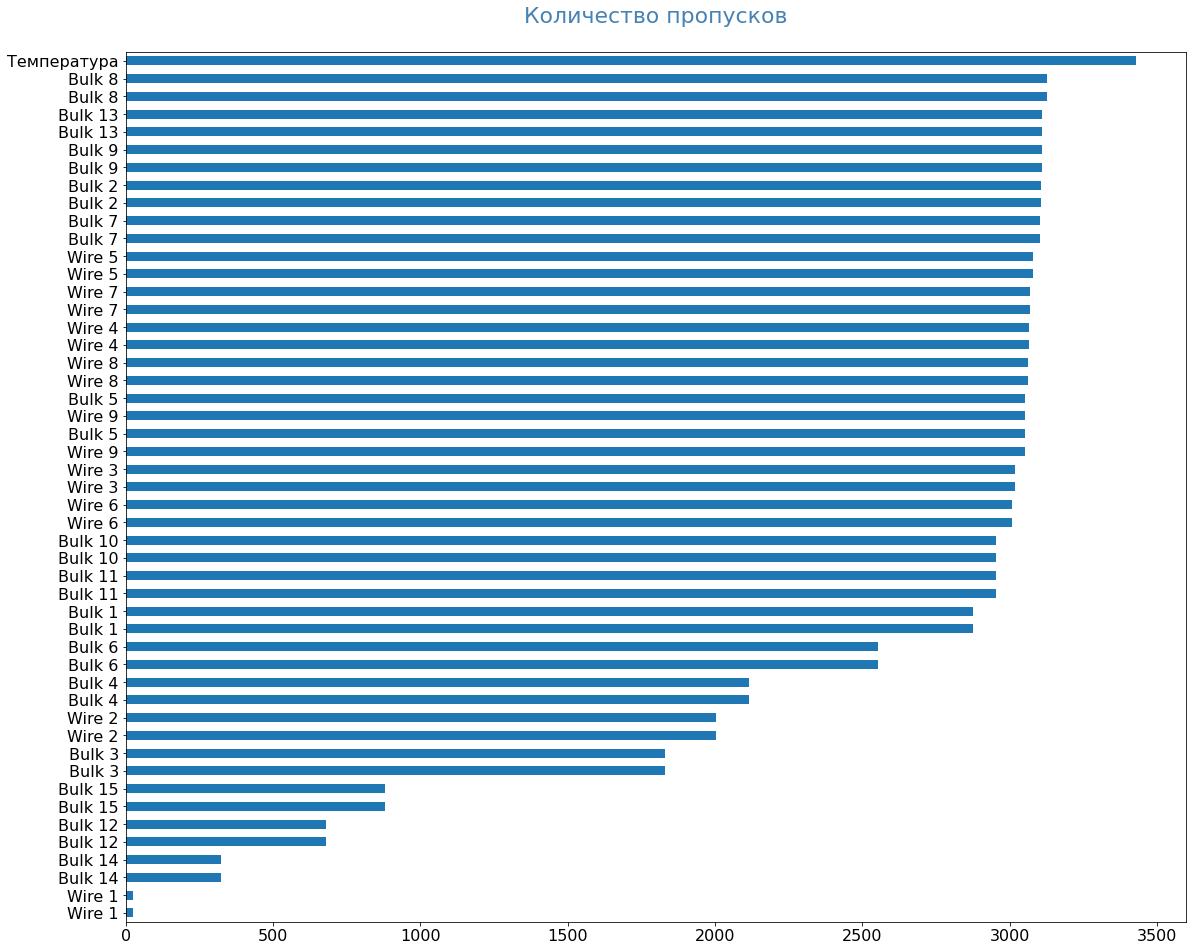

In [11]:
pass_value_barh(isna_all)

Мы видим большое количество пропусков в колонках с добавлением сыпучих и проволочных материалов, а так же дат этих событий.
Так же есть пропуски в температуре. Наличие пропусков в добавлении материалов скорее всего связано с тем, что не для всех видов стали использовались те или иные материалы. 

Чтобы убедиться, что пропуски в добавлении материалов вызваны вышеизложенными причинами, а не из-за ошибок в замерах или заполнении, проверим гипотезу.

<b>Гипотеза</b>

Пропуски в количестве и времени добавления одного и того же материала совпадают. 

<b>Проверка гипотезы</b>
Для пар датасетов (с количеством и временем добавления материалов соотвественно) проверим, встречаются ли такие ситуации, когда в одном датасете в определённой колонке есть пропуск, а в другом нет:

In [12]:

(data_bulk_new.isna() & ~data_bulk_time_new.isna()).sum(), (data_wire_new.isna() & ~data_wire_time_new.isna()).sum()

(key        0
 Bulk 1     0
 Bulk 2     0
 Bulk 3     0
 Bulk 4     0
 Bulk 5     0
 Bulk 6     0
 Bulk 7     0
 Bulk 8     0
 Bulk 9     0
 Bulk 10    0
 Bulk 11    0
 Bulk 12    0
 Bulk 13    0
 Bulk 14    0
 Bulk 15    0
 dtype: int64,
 key       0
 Wire 1    0
 Wire 2    0
 Wire 3    0
 Wire 4    0
 Wire 5    0
 Wire 6    0
 Wire 7    0
 Wire 8    0
 Wire 9    0
 dtype: int64)

Как видим, гипотеза подтвердилась. Прпоуски в материалах связаны не с ошибкой, а с тем, что для разных сортов стали используются разные материалы.

Про остальные пропуски сказать ничего нельзя. Что касается температуры, это целевое значение, потому придётся удалить пропуски температуры, что будет сделано в дальнейшем.

In [13]:
data_bulk_new.fillna(0, inplace = True)
data_wire_new.fillna(0, inplace = True)
data_bulk_new.isna().sum(), data_wire_new.isna().sum()

(key        0
 Bulk 1     0
 Bulk 2     0
 Bulk 3     0
 Bulk 4     0
 Bulk 5     0
 Bulk 6     0
 Bulk 7     0
 Bulk 8     0
 Bulk 9     0
 Bulk 10    0
 Bulk 11    0
 Bulk 12    0
 Bulk 13    0
 Bulk 14    0
 Bulk 15    0
 dtype: int64,
 key       0
 Wire 1    0
 Wire 2    0
 Wire 3    0
 Wire 4    0
 Wire 5    0
 Wire 6    0
 Wire 7    0
 Wire 8    0
 Wire 9    0
 dtype: int64)

#### Пропуски в целевом значении 
По условию задачи, целевое значение - последний замер температуры для каждой партии. Возможна ситуация, когда пропуск в температуре как раз затрагивают именно его. По сути, нам не так важно, если пропуск будет во время второго замера, однако недопустимо, когда пропуск находится в первом или последнем замерах. Потому мы заполним пропуски в температуре значением 100. Это явный выброс и в дальнейшем мы сможем понять, когда первый или последний замер равен этому значению и убрать уже из аггрегированной таблицы.

In [14]:
data_temp_new.fillna(100, inplace = True)
data_temp_new = data_temp_new.reset_index(drop=True)
data_temp_new.isna().sum(), data_temp_new.shape

(key             0
 Время замера    0
 Температура     0
 dtype: int64,
 (18092, 3))

#### Вывод
Были проанализированы пропуски. Большая их часть связано с технологическим процессом (не всегда использовались все добавки). Остальные пропуски, видимо - ошибка заполнения или сбои в системах измерения. 

Пропуски в добавках были заполненны нулями, остальные удалены, так как в них содержалась целевая переменная.

### Анализ выросов

#### data_arc_new

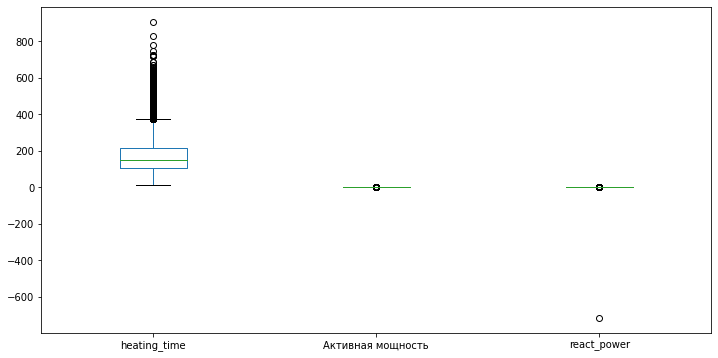

In [15]:
data_arc_new.rename(columns = {'Реактивная мощность':'react_power'}, inplace = True)
l = list(data_arc_new.columns)
l.remove('key')
data_arc_new[l].plot(kind = 'box', figsize = (12,6));


Как видим, есть выбросы в heating_time, а так же реактивной мощностьи (большое отрицательное значение). Взглянем подробней на время нагрева.

count    14876.000000
mean       171.670946
std         98.186803
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: heating_time, dtype: float64

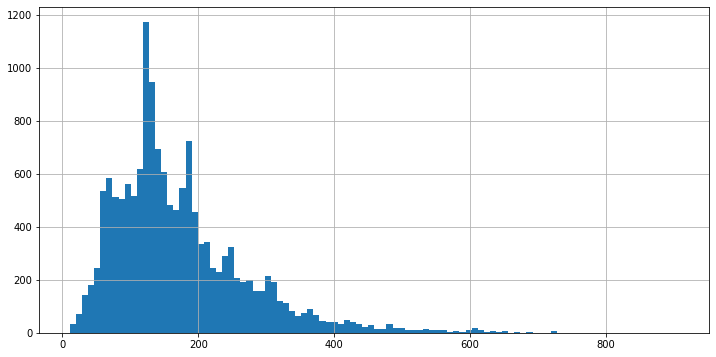

In [16]:
data_arc_new['heating_time'].hist(bins = 100, figsize = (12,6));
data_arc_new['heating_time'].describe()

Распределение похоже на нормальное. Мы видим наличие малых и больших значений. Возможно, это зависит от сортов стали, а так же от шагов её приготовления.
Тем не менее, выбросы могут помешать нам в работе.


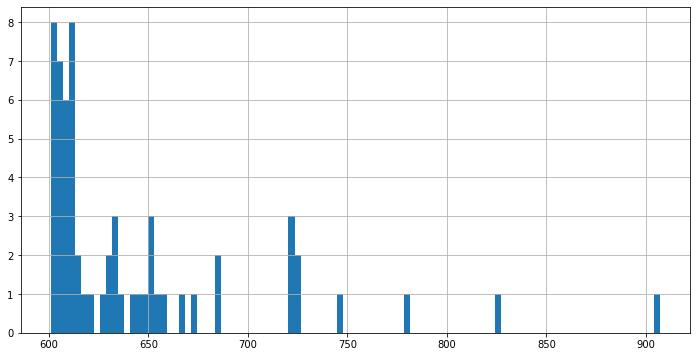

In [17]:
data_arc_new.query('heating_time > 600')['heating_time'].hist(bins = 100, figsize = (12,6));


Мы видим явные одиночные выбросы > 650, однако эти значения возможны и в реальности, потому оставляем.

Уберём выброс реактивной мощности и посмотрим снова:

Index(['key', 'Начало нагрева дугой', 'heating_time', 'Активная мощность',
       'react_power'],
      dtype='object')

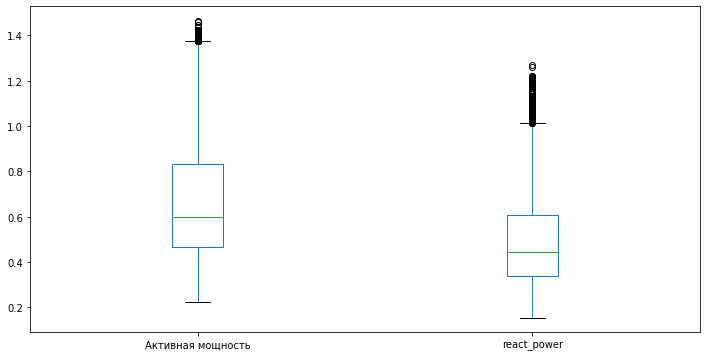

In [18]:

data_arc_new = data_arc_new.query('react_power >= 0')
l.remove('heating_time')
data_arc_new[l].plot(kind = 'box', figsize = (12,6))
data_arc_new.columns

Тут всё впорядке.

#### data_bulk_new

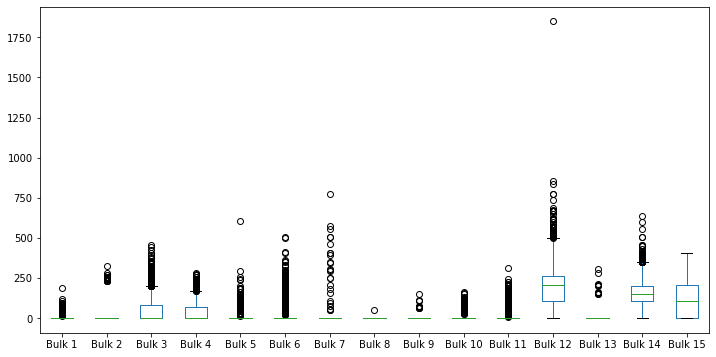

In [19]:
l = list(data_bulk_new.columns)
l.remove('key')
data_bulk_new[l].plot(kind = 'box', figsize = (12,6));


Мы видим огромные выбросы в Bulk_5 и Bulk_12, однако они возможны в реальной практике, потому не будем удалять.

In [20]:
data_bulk_new.rename(columns = {'Bulk 5':'Bulk_5'}, inplace = True)
data_bulk_new.rename(columns = {'Bulk 12':'Bulk_12'}, inplace = True)

l = list(data_bulk_new.columns)
l.remove('key')

#### data_wire_new

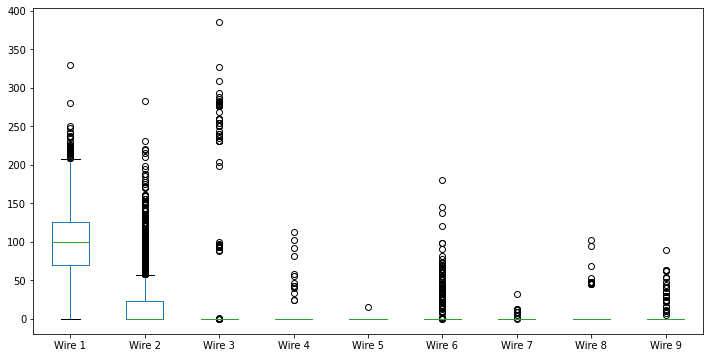

In [21]:
l = list(data_wire_new.columns)
l.remove('key')
data_wire_new[l].plot(kind = 'box', figsize = (12,6));

Здесь выбросы не столь существенны, оставляем.

#### data_gas_new 

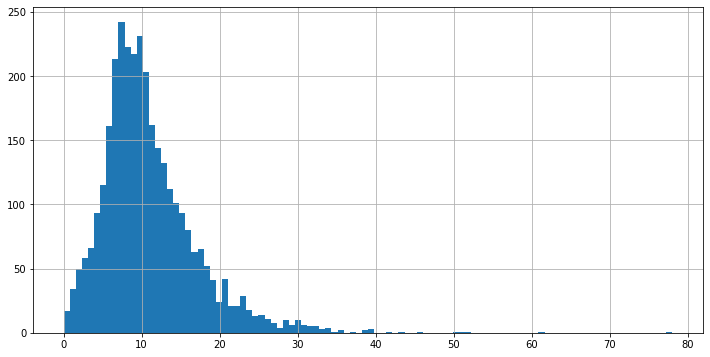

In [22]:
data_gas_new['Газ 1'].hist(bins = 100, figsize = (12,6));

Мы видим явные выбросы, посмотрим подробней.

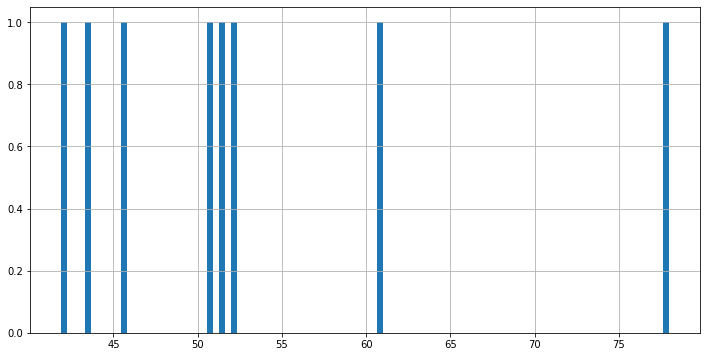

In [23]:
data_gas_new.rename(columns = {'Газ 1':'gas_1'}, inplace = True)
data_gas_new.query('gas_1 >= 40')['gas_1'].hist(bins = 100, figsize = (12,6));

Оставляем по тому же принципу

#### data_temp_new

Мы помним, что пропуски заполнили значениями 100 градусов, потому не учитываем их при построенгии гистограммы.

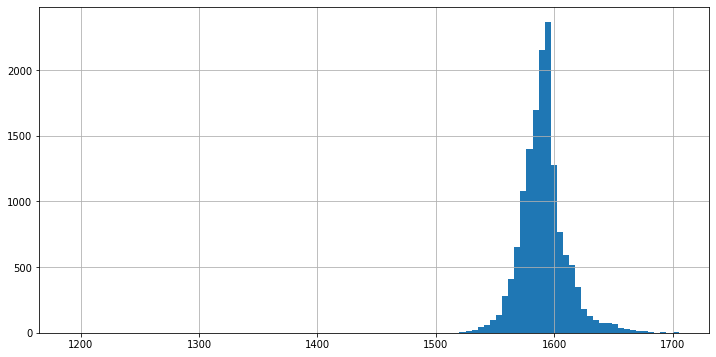

In [24]:
data_temp_new.query('Температура > 100')['Температура'].hist(bins=100, figsize = (12,6));

Мы знаем, что сталь производится при высоких температурах. Значения 1200 и около того - явные выбросы. По графику видно, что большая часть значений температуры больше 1500. Посмотрим подробней на значения выбросов.

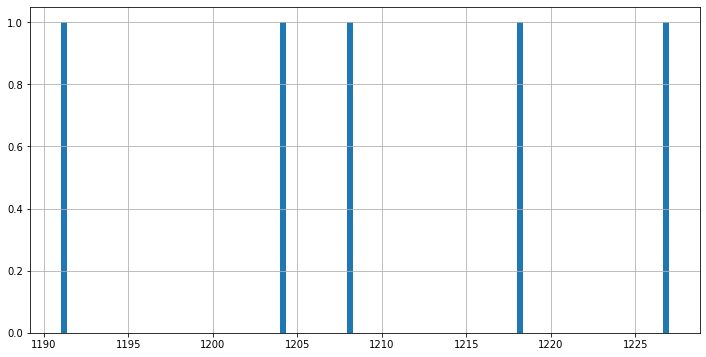

In [25]:
data_temp_new.query('Температура < 1500 and Температура > 100')['Температура'].hist(bins=100, figsize = (12,6));

Мы видим единичные выбросы для температур ниже 1500. Заменяем их на значение равное 100, чтобы при аггрегировании таблицы мы удалили те строчки, где начальная или конечная температура равна 100. Так мы будем знать, что там были пропуски или выбросы и данные следовательно не валидны.

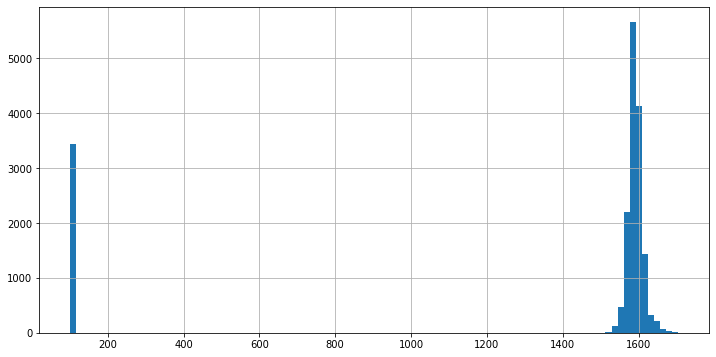

In [26]:
data_temp_new['Температура'] = \
data_temp_new['Температура'].where(data_temp_new['Температура'] >= 1500, 100)
data_temp_new = data_temp_new.reset_index(drop=True)
data_temp_new['Температура'].hist(bins=100, figsize = (12,6));


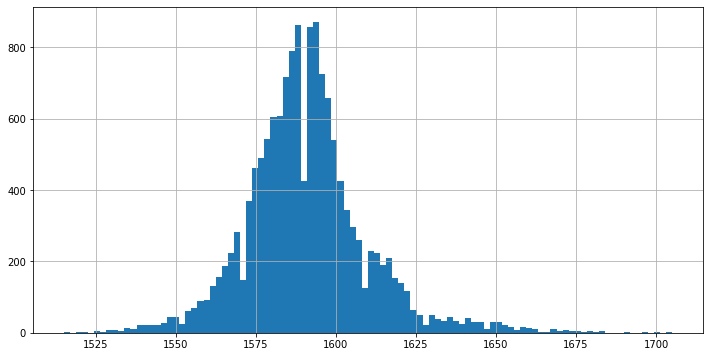

In [27]:
data_temp_new.query('Температура > 100')['Температура'].hist(bins=100, figsize = (12,6));

Мы успешно заменили выбросы на значения равные 100, которые удалим при аггрегировании таблицы.

#### Вывод
Были проанализированны выбросы. Мы удалили супервыбросы (температура < 1200 и отрицальтельная реактивная мощность), однако оставили остальное, так как это могут быть реальные значения.

### Агреггирование данных

#### data_arc_new

В таблице data_arc_new у нас есть следующие значимые параметры: время нагрева дугой, активная и реактивная мощности. Благодаря консультации с людьми, имеющими физическое образование, мы выяснили, что важным параметром является активная мощность, и реактивной можно пренебречь. 

Мы умножим активную мощность на время нагрева и затем в агреггирующей функции просуммируем, получив "энергию" (скорее всего, это некорректно с физической точки зрения но может оказаться полезным в плане обучения модели). Возможно значимым окажется и пиковая (максимальная) мощность. Кроме того, мы можем рассмотреть среднее "энергии".

In [28]:
data_arc_new['energy'] = data_arc_new['heating_time'] * data_arc_new['Активная мощность'] 
data_arc_new.drop(columns = ['Начало нагрева дугой', 'react_power'], inplace = True)


In [29]:
def arc_agg(x):
    d = {}
    d['heating_time_sum'] = x['heating_time'].sum()
    d['energy_sum'] = x['energy'].sum()
    d['energy_mean'] = x['energy'].mean()
    d['power_max'] = x['Активная мощность'].max()
    return pd.Series(d, index=['heating_time_sum', 'energy_sum', 'energy_mean', 'power_max'])

data_arc_new_agg = data_arc_new.groupby(by = 'key').apply(arc_agg)
data_arc_new_agg.reset_index(inplace= True )
data_arc_new_agg

,key,heating_time_sum,energy_sum,energy_mean,power_max
0,1,1098.0,628.616930,125.723386,0.867133
1,2,811.0,395.281800,98.820450,0.786322
2,3,655.0,581.774624,116.354925,1.222963
3,4,741.0,543.710274,135.927569,0.887855
4,5,869.0,412.180480,103.045120,0.892957
...,...,...,...,...,...
3209,3237,909.0,493.152191,98.630438,1.090839
3210,3238,546.0,229.390861,76.463620,0.623378
3211,3239,1216.0,751.674870,93.959359,0.894547
3212,3240,839.0,530.736187,106.147237,1.202454


#### data_bulk, data_wire, data_gas

Агреггируя добавки, мы возьмём сумму, так как скорее именно конечная сумма определяет целевую переменную. 

In [30]:
data_bulk_new_agg = data_bulk_new.groupby(by = 'key').agg('sum')
data_bulk_new_agg.reset_index(inplace= True )
data_wire_new_agg = data_wire_new.groupby(by = 'key').agg('sum')
data_wire_new_agg.reset_index(inplace= True )
data_gas_new_agg = data_gas_new.groupby(by = 'key').agg('sum')
data_gas_new_agg.reset_index(inplace= True )

#### data_temp

Нас интересует только первое и последнее время замера. Создадим два столбца - first_temp и last_temp. Именно last_temp - целевой параметр. В них запишем соответвенно температуру первого и последнего замера в каждом цикле. 

In [31]:
#df['count_max'] = df.groupby(['Sp', 'Mt'])['count'].transform(max)
data_temp_new_agg = data_temp_new.copy()
data_temp_new_agg['first_temp'] = 0
data_temp_new_agg['last_temp'] = 0
temp2 = 0
temp = 0
key_ = 0

for i in range(1, len(data_temp_new_agg)):
    temp = data_temp_new_agg.loc[i,'Температура']
    if i != 1:
        temp2 = data_temp_new_agg.loc[i - 1,'Температура']
    if data_temp_new_agg.loc[i,'key'] != key_:
        key_ = data_temp_new_agg.loc[i,'key']
        data_temp_new_agg.loc[i - 1,'last_temp'] = temp2
        if i > 1:
            data_temp_new_agg.loc[i,'first_temp'] = temp
        else:
            data_temp_new_agg.loc[i-1,'first_temp'] = data_temp_new_agg.loc[i-1,'Температура']
#data_temp_new_agg['key'] = data_temp_new_agg['key'].astype(int)
data_temp_new_agg.head(20)

,key,Время замера,Температура,first_temp,last_temp
0,1,2019-05-03 11:02:04,1571.0,1571.0,0.0
1,1,2019-05-03 11:07:18,1604.0,0.0,0.0
2,1,2019-05-03 11:11:34,1618.0,0.0,0.0
3,1,2019-05-03 11:18:04,1601.0,0.0,0.0
4,1,2019-05-03 11:25:59,1606.0,0.0,0.0
5,1,2019-05-03 11:30:38,1613.0,0.0,1613.0
6,2,2019-05-03 11:34:04,1581.0,1581.0,0.0
7,2,2019-05-03 11:38:40,1577.0,0.0,0.0
8,2,2019-05-03 11:46:09,1589.0,0.0,0.0
9,2,2019-05-03 11:49:38,1604.0,0.0,0.0


In [32]:
data_temp_new_agg.tail()

,key,Время замера,Температура,first_temp,last_temp
18087,3241,2019-09-06 16:55:01,100.0,0.0,0.0
18088,3241,2019-09-06 17:06:38,100.0,0.0,0.0
18089,3241,2019-09-06 17:21:48,100.0,0.0,0.0
18090,3241,2019-09-06 17:24:44,100.0,0.0,0.0
18091,3241,2019-09-06 17:30:05,100.0,0.0,0.0


Последнее значение неправильное, исправляем

In [33]:
data_temp_new_agg.loc[14659, 'last_temp'] = data_temp_new_agg.loc[14659, 'Температура']
data_temp_new_agg.tail()

,key,Время замера,Температура,first_temp,last_temp
18087,3241,2019-09-06 16:55:01,100.0,0.0,0.0
18088,3241,2019-09-06 17:06:38,100.0,0.0,0.0
18089,3241,2019-09-06 17:21:48,100.0,0.0,0.0
18090,3241,2019-09-06 17:24:44,100.0,0.0,0.0
18091,3241,2019-09-06 17:30:05,100.0,0.0,0.0


Мы успешно определили первую и последнюю температуру (во время промежуточных значений, эти параметры равны нулю)

In [34]:
data_temp_new_agg.drop(columns = ['Время замера', 'Температура'], inplace = True)
data_temp_new_agg = data_temp_new_agg.groupby(by = 'key').agg('max')
data_temp_new_agg.reset_index(inplace = True)
data_temp_new_agg.head(10)

,key,first_temp,last_temp
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
5,6,1543.0,1596.0
6,7,1586.0,1599.0
7,8,1577.0,1598.0
8,9,1587.0,1592.0
9,10,1574.0,1593.0


Смотрим, попали ли выбросы и пропуски в первый и последний замеры.

In [35]:
data_temp_new_agg.query('first_temp == 100 or last_temp == 100').shape

(741, 3)

Как видим, такое произошло. Удаляем

In [36]:
data_temp_new_agg = data_temp_new_agg.query('first_temp > 100 and last_temp > 100')
data_temp_new_agg.query('first_temp == 100 or last_temp == 100').shape

(0, 3)

In [37]:
data_temp_new_agg['first_temp'].describe()

count    2474.000000
mean     1589.028294
std        24.998342
min      1519.000000
25%      1572.000000
50%      1588.000000
75%      1605.000000
max      1679.000000
Name: first_temp, dtype: float64

In [38]:
data_temp_new_agg['last_temp'].describe()

count    2474.000000
mean     1595.347615
std        16.035205
min      1541.000000
25%      1587.000000
50%      1593.000000
75%      1599.000000
max      1700.000000
Name: last_temp, dtype: float64

Как видим, выбросов и аномалий не осталось, данные корректны.

#### Вывод
Данные, которые в дальнейшем будут использоваться, были сагреггированы по значению key. Были найдены значения температуры для первого замера (признак) и последнего замера в партии (целевое значение).

Возможно не все данные будут использованы, поскольку данные arc могут быть коллинеарны. 

### Анализ добавок и сортов стали
#### Избавление от лишних признаков

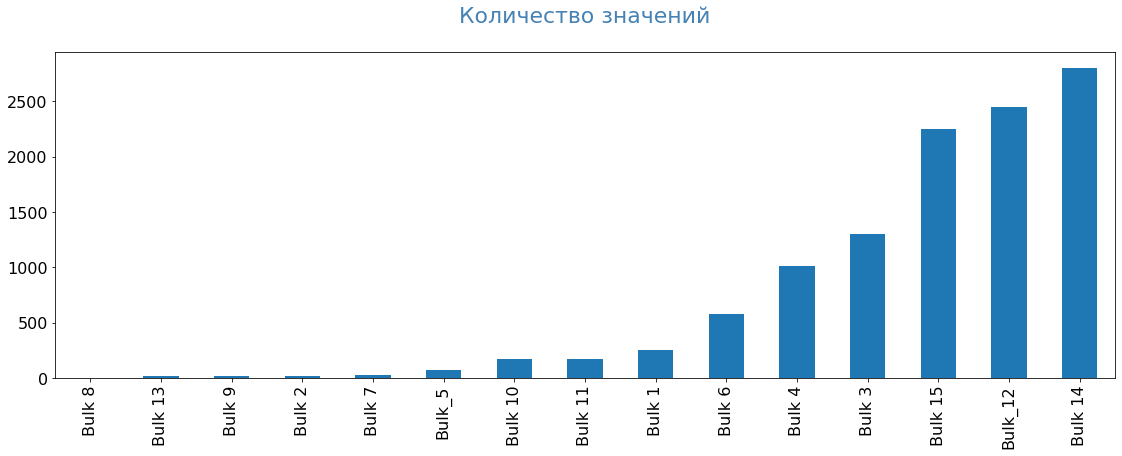

In [39]:
b = data_bulk_new_agg.count() - (data_bulk_new_agg == 0).sum()
b = b.to_frame()
b = b.rename(columns = {0:'count'})
b.drop(index = 'key', inplace = True)
(
b.sort_values(by = 'count', ascending = True).
    plot(kind = 'bar', figsize = (19,6),  legend = False, fontsize = 16).
    set_title('Количество значений' + "\n", fontsize = 22, color = 'SteelBlue')
    
);

Мы видим, что количество добавок Bulk 5 и меньше - незначительно. Предлагаю объединить их значение в один столбец.

In [40]:
data_bulk_new_agg['Bulk_other'] = data_bulk_new_agg['Bulk 8'] + data_bulk_new_agg['Bulk 13'] + \
data_bulk_new_agg['Bulk 9'] + data_bulk_new_agg['Bulk 2'] + data_bulk_new_agg['Bulk 7'] +\
data_bulk_new_agg['Bulk_5']
data_bulk_new_agg.drop(columns = ['Bulk 8', 'Bulk 13', 'Bulk 9', 'Bulk 2', 'Bulk 7', 'Bulk_5'], inplace = True )
data_bulk_new_agg.head()

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk_12,Bulk 14,Bulk 15,Bulk_other
0,1,0.0,0.0,43.0,0.0,0.0,0.0,206.0,150.0,154.0,0.0
1,2,0.0,0.0,73.0,0.0,0.0,0.0,206.0,149.0,154.0,0.0
2,3,0.0,0.0,34.0,0.0,0.0,0.0,205.0,152.0,153.0,0.0
3,4,0.0,0.0,81.0,0.0,0.0,0.0,207.0,153.0,154.0,0.0
4,5,0.0,0.0,78.0,0.0,0.0,0.0,203.0,151.0,152.0,0.0


Проверяем wire

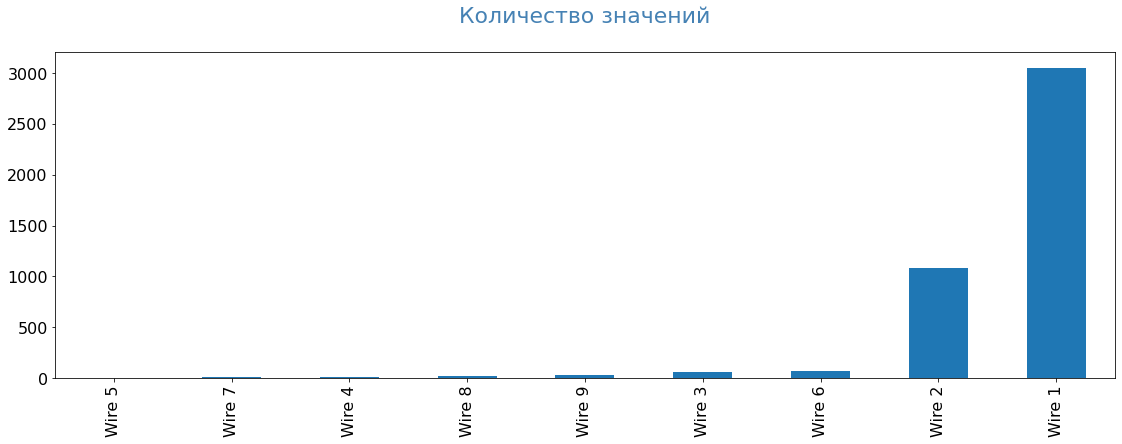

In [41]:
b = data_wire_new_agg.count() - (data_wire_new_agg == 0).sum()
b = b.to_frame()
b = b.rename(columns = {0:'count'})
b.drop(index = 'key', inplace = True)
(
b.sort_values(by = 'count', ascending = True).
    plot(kind = 'bar', figsize = (19,6),  legend = False, fontsize = 16).
    set_title('Количество значений' + "\n", fontsize = 22, color = 'SteelBlue')
    
);

Тут мы видим схожую ситуацию : добавок кроме Wire 1 и Wire 2 мало. Разумно объединить их в Wire_other

In [42]:
data_wire_new_agg['wire_other'] = data_wire_new_agg['Wire 5'] + data_wire_new_agg['Wire 7'] + \
data_wire_new_agg['Wire 4'] + data_wire_new_agg['Wire 8'] + data_wire_new_agg['Wire 9'] +\
data_wire_new_agg['Wire 3'] + data_wire_new_agg['Wire 6']
data_wire_new_agg.drop(columns = ['Wire 5', 'Wire 7', 'Wire 4', 'Wire 8', 'Wire 9', 'Wire 3', 'Wire 6'], inplace = True )
data_wire_new_agg.head()

,key,Wire 1,Wire 2,wire_other
0,1,60.059998,0.00000,0.0
1,2,96.052315,0.00000,0.0
2,3,91.160157,0.00000,0.0
3,4,89.063515,0.00000,0.0
4,5,89.238236,9.11456,0.0


#### Вывод
Были изменены таблицы с добавками, так как часть добавок используется крайне редко. Редкие добавки были отнесены к одной категории "другое". Это помогло уменьшить размерность таблицы, что хорошо скажется на скорости обучении моделей, кроме того, это помогло избавиться от лишних признаков, из-за которых модель могла бы работь хуже.



### Создаём итоговую таблицу

In [43]:
df = data_temp_new_agg.merge(data_arc_new_agg, on = 'key', how = 'inner').\
merge(data_bulk_new_agg, on = 'key', how = 'inner').\
merge(data_wire_new_agg, on = 'key', how = 'inner').\
merge(data_gas_new_agg, on = 'key', how = 'inner')
#merge(sorts, on = 'key', how = 'inner')
df['target'] = df['last_temp']
df.drop(columns= 'last_temp', inplace = True)
dfAAA = pd.read_csv('/datasets/data_temp_new.csv')
dfAAA.query('key>=3000')

,key,Время замера,Температура
16804,3000,2019-08-29 09:48:33,1609.0
16805,3000,2019-08-29 09:53:47,NaN
16806,3000,2019-08-29 10:00:59,NaN
16807,3000,2019-08-29 10:06:16,NaN
16808,3001,2019-08-29 10:23:59,1585.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [44]:
df

,key,first_temp,heating_time_sum,energy_sum,energy_mean,power_max,Bulk 1,Bulk 3,Bulk 4,Bulk 6,...,Bulk 11,Bulk_12,Bulk 14,Bulk 15,Bulk_other,Wire 1,Wire 2,wire_other,gas_1,target
0,1,1571.0,1098.0,628.616930,125.723386,0.867133,0.0,0.0,43.0,0.0,...,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,1613.0
1,2,1581.0,811.0,395.281800,98.820450,0.786322,0.0,0.0,73.0,0.0,...,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,1602.0
2,3,1596.0,655.0,581.774624,116.354925,1.222963,0.0,0.0,34.0,0.0,...,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,1599.0
3,4,1601.0,741.0,543.710274,135.927569,0.887855,0.0,0.0,81.0,0.0,...,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,1625.0
4,5,1576.0,869.0,412.180480,103.045120,0.892957,0.0,0.0,78.0,0.0,...,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,2495,1570.0,723.0,571.539318,142.884829,1.055713,0.0,21.0,0.0,0.0,...,0.0,256.0,129.0,223.0,0.0,89.150879,0.00000,0.0,7.125735,1591.0
2321,2496,1554.0,940.0,675.222467,112.537078,1.309449,0.0,0.0,63.0,0.0,...,0.0,256.0,129.0,226.0,0.0,114.179527,0.00000,0.0,9.412616,1591.0
2322,2497,1571.0,569.0,680.326674,226.775558,1.270521,0.0,0.0,85.0,0.0,...,0.0,230.0,124.0,226.0,0.0,94.086723,9.04800,0.0,6.271699,1589.0
2323,2498,1591.0,750.0,474.918795,94.983759,0.999939,0.0,90.0,0.0,0.0,...,0.0,206.0,129.0,207.0,0.0,118.110717,0.00000,0.0,14.953657,1594.0


#### Анализ корреляций

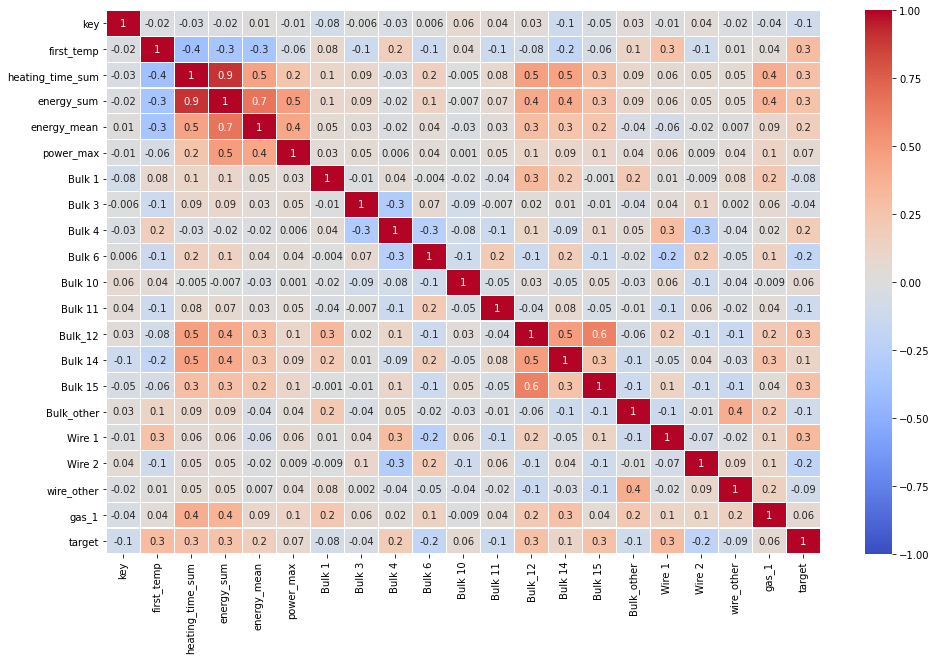

In [45]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(16,10))  
sns.heatmap(df_corr, vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm'
           ,linewidths= .1, fmt='.1g' );

Мы видим в некоторых местах довольно сильную корелляцию (не считая диагонали, там она всегда единица). Попробуем посмотреть на большие значения.

In [46]:
big_corr = []
for i in df_corr:
    for e in (df_corr.columns):
        if df_corr.loc[i, e] < 1:
           big_corr.append([i,e, df_corr.loc[i, e]])
big_corr.sort(key=itemgetter(2), reverse=True)

last_corr = 0
big_corr_sorted = []
for i in big_corr:
    if i[2] != last_corr:
        big_corr_sorted.append(i)
        last_corr = i[2]

        
big_corr = []
for i in big_corr_sorted:
    s = i[0] + ' AND ' + i[1]
    big_corr.append([s, i[2]])
df_corr = pd.DataFrame(big_corr)

df_corr = df_corr.set_index(0)

In [47]:
df_corr = df_corr.rename(columns = {1:'corr'})

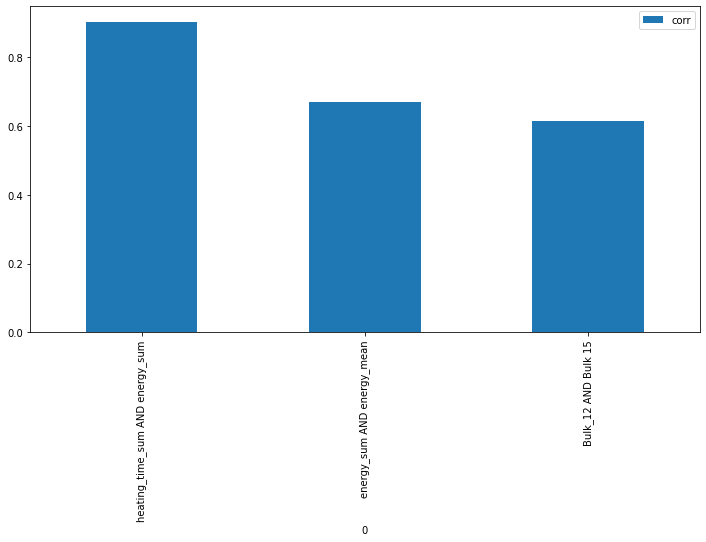

In [48]:

pd.concat([df_corr.query('corr >= 0.5'), df_corr.query('corr <= -0.5')]).plot(kind = 'bar', figsize = (12,6));

Мультиколлинеарными можно считать признаки, значения корелляции которых > 0.6. Здесь мы рассмотрели те, значения которых >= 0.5

Больше всего кореллируют время нагрева и сумма "энергии", а также сумма и среднее "энергии". Следовательно, при обучении моделей мы будем использовать что-то одно из этого. Также кореллируют сыпучие добавки 12 и 15. Очевидно, они связаны между собой таким образом, что для изменения состава стали используются обе добавки в определённых пропорциях.

Также кореллируют начальная и итоговая температура, но в данном случае, это хорошо.

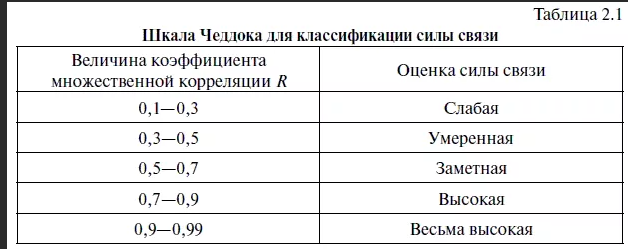

#### Вывод

Мы объединили все данные в одну таблицу. Согласно задаче, мы объеденили таким образом, чтобы оставались только те строки, в которых есть все данные.

Также проверили данные на мультиколлинеарность и сделали выводы.

### Вывод по анализу данных

Мы загрузили данные и провели предварительный анализ.
Были выполнены следующие шаги:

- Мы загрузили данные и привели их в надлежащий формат
- Мы проанализировали пропуски, а также заполнили их или удалили, в зависимости от ситуации
- Мы провели анализ выбросов и избавились от них там, где это необходимо
- Мы сагреггировали данные по столбцу 'key'
- Мы объединили те столбцы, в которых мало значений, уменьшив размерность данных
- Мы создали категориальный признак "сорта" стали (в дальнейшем станет понятно, нужен он или нет)
- Мы проверили данные на мультиколлениарность и сделали выводы


## Обучение моделей

### Предподготовка данных

По условию задачи, делим выборку в пропорции 75% к 25%.

In [49]:

X = df.drop(columns = ['target', 'key']).copy()
y = df['target'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=80523, shuffle=True)
X_train.shape, X_test.shape

((1743, 19), (582, 19))

### Создание новой категориальной переменной

Судя по неоднородности и количеству разных добавок, завод варит сталь разных сортов. К сожалению, заказчик не предоставил нам эту информацию, но возможно мы сможем сами получить эти значения. Мы сделаем предположение, что в разные сорта добавляют разные типы добавок. В зависимости от наличия или отсутствия той или иной добавки сталь будет отнесена к определённому сорту. Для маркировки сортов мы будем использовать числа, образованные из двоичной записи. 

Конечно, это может не соотвествовать реальности, например какая-то добавка может просто не требоваться для изменения состава и это зависит от руды, а не от стали, однако, возможно всё же это улучшит модель - будем проверять уже на самой моделе.

По условии задачи, мы не знаем, что находится в тестовых данных. Таким образом, там могут быть те категории, которых нет в тренировочных. Потому, создадим класс, который сможет запомнить какие "категории" есть в тренировочных данных, затем, преобразуя тестовые данные, всем новым классам он назначит значение other. 

Сощздадим список с колонками с добавками

In [50]:
sorts_columns = list(data_bulk_new_agg.copy().merge(data_wire_new_agg, on = 'key', how = 'inner').columns)
sorts_columns.remove('key')
sorts_columns


['Bulk 1',
 'Bulk 3',
 'Bulk 4',
 'Bulk 6',
 'Bulk 10',
 'Bulk 11',
 'Bulk_12',
 'Bulk 14',
 'Bulk 15',
 'Bulk_other',
 'Wire 1',
 'Wire 2',
 'wire_other']

Чтобы функция создания категории работала корректно, обновим индексы, а также "скопируем" наши фреймы, чтобы не было warring'ов

In [51]:
X_train_cat = X_train.copy()
y_train_cat = y_train.copy()
X_test_cat = X_test.copy()
y_test_cat = y_test.copy()


X_train_cat.reset_index(drop = True, inplace = True)
y_train_cat.reset_index(drop = True, inplace = True)
X_test_cat.reset_index(drop = True, inplace = True)
y_test_cat.reset_index(drop = True, inplace = True)


Напишем класс, который создаёт новую категориальную переменную. Он будет возвращать стобец "sort", который будет содержать закодированные "сорта" стали. Класс утроен таким образом, чтобы запоминать уникальные "сорта" в тестовых данных, а затем 

In [52]:
class catfeature:
    def __init__(self):
        #Переменная для уникальных колонок
        self.unique_columns = []
        
    def fit_transform(self,
                      X, #датафремй, который мы будем обрабатывать
                      columns, #колонки, которые будем учитывать
                      train = True, #если истина, то обрабатываем тренировочный датасет, иначе - тестовый
                      min_count = 10, #минимальное количество уникальных значений категории 
                      another_label = 'another' #Как будем называть новые категории в тестовых данных?
                     ):
        self.X = X.copy()
        self.X['sort'] = 0 #Инициализируем возвращаемое значение
        sort = ''
        for i in range(len(self.X)):
            
            sort = '1'
            for e in columns: #Проходим по всем колонкам, и добавляем к сорту 1 если добавка есть, а иначе 0
                if self.X.loc[i, e] == 0:
                    sort += '0'
                else:
                    sort += '1'
        
            sort2 = int(sort, 2)
        
            self.X.loc[i,'sort'] = 'SORT_' + str(sort2) #переводим в категориальную переменную 
            

          # В случае, если данные тренировочные, всем категориям, которые имет меньше значений чем min_count присваеваем
          # значение another
        if train == True: 
            a = self.X.sort.value_counts()
            m = self.X.sort.isin(a.index[a<= min_count])
            self.X.loc[m, 'sort'] = 'another'
            self.unique_columns = list(self.X['sort'].unique()) #Запоминаем все категории, 
                                                                #которые получили на тренировочных данных
        else:
            #Для тестовых данных смотрим, является ли категория новой или старой. Если новая, то присваиваем ей значение,
            #записанное в another_label (по умолчанию также another). 
            #Это нужно тчобы не вышли ошибки при кодировании на тестовых данных
            self.X['sort'] = self.X['sort'].where(self.X['sort'].isin(self.unique_columns), another_label) 
        return self.X['sort']

Применем наш класс к тренировочным и тестовым данным

In [53]:
catfeature_ = catfeature()
X_train_cat['sort']= catfeature_.fit_transform(X = X_train_cat, columns = sorts_columns,train = True, min_count=20)
X_test_cat['sort']= catfeature_.fit_transform(X = X_test_cat, columns = sorts_columns,train = False)

len(list(X_train_cat['sort'].unique())), len(list(X_test_cat['sort'].unique()))

(17, 17)

In [54]:
X_train_cat.head()

,first_temp,heating_time_sum,energy_sum,energy_mean,power_max,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk_12,Bulk 14,Bulk 15,Bulk_other,Wire 1,Wire 2,wire_other,gas_1,sort
0,1610.0,459.0,306.407446,102.135815,0.852833,0.0,0.0,0.0,0.0,0.0,0.0,206.0,104.0,106.0,0.0,134.269195,17.13088,0.0,2.104704,SORT_8310
1,1584.0,612.0,404.161008,101.040252,1.000753,0.0,0.0,0.0,0.0,0.0,0.0,256.0,151.0,203.0,0.0,138.902390,0.00000,0.0,4.111752,SORT_8308
2,1580.0,290.0,139.927971,46.642657,0.489523,0.0,0.0,0.0,181.0,0.0,0.0,0.0,139.0,0.0,0.0,80.152794,0.00000,0.0,7.655662,another
3,1603.0,336.0,250.419246,62.604811,1.005672,0.0,38.0,0.0,0.0,0.0,0.0,157.0,212.0,106.0,0.0,165.344403,0.00000,0.0,6.423889,SORT_10356
4,1591.0,949.0,588.939659,84.134237,0.887130,0.0,0.0,0.0,321.0,0.0,25.0,0.0,105.0,203.0,0.0,92.033760,0.00000,0.0,10.508564,another


Как видим, мы успешно создали новую категориальную переменную. В ней 31 категория.

### Обучение моделей

Мы попробуем обучить несколько моделей, постараясь добиться лучшего качества. Как мы можем это сделать?
- Попробуем учитывать категориальную переменную и нет
- Мы можем попробовать исключить некоторые столбцы и соотвественно перебрать модели с разным исключением
- Мы можем попробовать преобразовать данные, добавив полиномиальные преобразования

Напишем функцию, которая будет создавать из списка множество подмножеств списка (включая пустой список и весь список)

In [55]:
def all_sublists(l):
    return chain(*(combinations(l, i) for i in range(len(l) + 1))) 

def feature_selection(features):

    result = list(all_sublists(features))
    res = [list(ele) for ele in result] #На выходе имеем список кортежей, что нам не подойдёт, потому преобразум его в 
    #список списков
    return res

In [56]:
drop_columns = ['heating_time_sum', 'energy_sum', 'energy_mean', 'power_max', 'Bulk_12', 'Bulk 15']
#Возможно, какие-то из вышеуказанных колонок нужно выбросить. применем к ним нашу функцию

drop_columns = feature_selection(drop_columns)


Убедимся, что функция работает корректно

In [57]:
feature_selection([1,2,3])

[[], [1], [2], [3], [1, 2], [1, 3], [2, 3], [1, 2, 3]]

Как видим, всё работает корректно

Добавим функцию, которая добавляет в данные все возможные перемножения n-ной степени, т.е. если признаки x и y, то функция добавиь столбцы xy, x^2, y^2, x^2*y и так далее, в зависимости от параметра n.

In [58]:
def n_transformation(data, n=2, target = False):
    df = data.copy()
    df2 = df.copy()
    
    for i in range(n - 1):
        
        features = list(df.columns)
        #Мы не будем перебирать Таргет, если он указан
        if target != False:
            del features[features.index(target)]
        features2 = list(df2.columns)
        #Мы не будем перебирать Таргет, если он указан
        if target != False:
            del features2[features2.index(target)]
        for i2 in range(len(features2)):
            for i3 in range(len(features)):
                e2 = features2[i2]
                e3 = features[i3]
                if i3 > i2:
                    df[e2+'*'+e3] = df[e2] * df[e3]
                else:
                    df[e3+'*'+e2] = df[e3] * df[e2]
    return df

In [59]:
final = []

#### LinearRegression (без учёта категорий)

In [60]:
model = LinearRegression()
linear_params = {}
best_err = 0
best_drop = []
best_model = None
for i in tqdm(drop_columns):
    X = X_train.copy()
    X.drop(columns = i, inplace = True)

    LinearNotCat = GridSearchCV(model, param_grid = {}, cv = 5,scoring = 'neg_mean_absolute_error', verbose = 0)
    LinearNotCat.fit(X, y_train)
    
    
    if LinearNotCat.best_score_ > best_err or best_err == 0:
        best_err = LinearNotCat.best_score_
        best_drop = i
        best_model = LinearNotCat.best_estimator_

print(best_err, 'Исключаем колонки: ', best_drop)

final_ = ['Линейная регрессия',best_model, best_err, best_drop, 'Not Cat']
final.append(final_)


  0%|          | 0/64 [00:00<?, ?it/s]

-6.273659770707928 Исключаем колонки:  ['power_max', 'Bulk_12']


Наилучшие результаты мы получаем, когда исключаем колонки ['power_max', 'Bulk_12']

Попробуем использовать функцию n_transformation.

In [61]:
model = LinearRegression()
linear_params = {}
best_err = 0
X = X_train.copy()
X.drop(columns = best_drop, inplace = True)
for i in tqdm(range(0,3)):
    X2 = X.copy()
    X2 = n_transformation(X, n=i, target = False)

    LinearNotCat = GridSearchCV(model, param_grid = {}, cv = 5,scoring = 'neg_mean_absolute_error', verbose = 0)
    LinearNotCat.fit(X2, y_train)
    
    
    if LinearNotCat.best_score_ > best_err or best_err == 0:
        best_err = LinearNotCat.best_score_
        best_drop = i
        
print(best_err, 'Степень многочлена: ', best_drop)

  0%|          | 0/3 [00:00<?, ?it/s]

-6.273659770707928 Степень многочлена:  0


В результате лучшие параметры мы видим при степени многочлена равной нулю (т.е. данные в первозданном виде). Вывод: полиномилальное преобразование бесполезно.

#### LinearRegression (c учётом категорий)

Используем get_dummies чтобы преобразовать категориальную переменную.

In [62]:
X_train_cat_linear = pd.get_dummies(X_train_cat, columns=['sort'], drop_first= True)
X_train_cat_linear.head()

,first_temp,heating_time_sum,energy_sum,energy_mean,power_max,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,...,sort_SORT_13428,sort_SORT_8308,sort_SORT_8310,sort_SORT_8564,sort_SORT_8820,sort_SORT_8822,sort_SORT_9220,sort_SORT_9332,sort_SORT_9334,sort_another
0,1610.0,459.0,306.407446,102.135815,0.852833,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
1,1584.0,612.0,404.161008,101.040252,1.000753,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,1580.0,290.0,139.927971,46.642657,0.489523,0.0,0.0,0.0,181.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,1603.0,336.0,250.419246,62.604811,1.005672,0.0,38.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,1591.0,949.0,588.939659,84.134237,0.887130,0.0,0.0,0.0,321.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [63]:
model = LinearRegression()
linear_params = {}
best_err = 0
best_drop = []
for i in tqdm(drop_columns):
    X = X_train_cat_linear.copy()
    X.drop(columns = i, inplace = True)

    LinearCat = GridSearchCV(model, param_grid = {}, cv = 5,scoring = 'neg_mean_absolute_error', verbose = 0)
    LinearCat.fit(X, y_train)
    
    
    if LinearCat.best_score_ > best_err or best_err == 0:
        best_err = LinearCat.best_score_
        best_drop = i
        best_model = LinearCat.best_estimator_
print(best_err, 'Исключаем колонки: ', best_drop)

final_ = ['Линейная регрессия',best_model, best_err, best_drop, 'Cat']
final.append(final_)

  0%|          | 0/64 [00:00<?, ?it/s]

-6.306126839464592 Исключаем колонки:  ['power_max', 'Bulk_12']


Наша функция выкидывает те же столбцы, при том результат от добавлении категорий только хуже.

####  DecisionTreeRegressor (без учёта категорий)

In [64]:
model = DecisionTreeRegressor(random_state= 80523)
tree_params = {'max_depth': range(1,21,5), 'min_samples_leaf': [1,10,20]}
best_err = 0
best_drop = []
best_params = []
for i in tqdm(drop_columns):
    X = X_train.copy()
    X.drop(columns = i, inplace = True)

    TreeNotCat = GridSearchCV(model, param_grid = tree_params, cv = 5,scoring = 'neg_mean_absolute_error', 
                              verbose = 0)
    TreeNotCat.fit(X, y_train)
    
    
    if TreeNotCat.best_score_ > best_err or best_err == 0:
        best_err = TreeNotCat.best_score_
        best_drop = i
        best_params = TreeNotCat.best_params_
        best_model = TreeNotCat.best_estimator_
print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)

final_ = ['Дерево решений',best_model, best_err, best_drop, 'Not Cat']
final.append(final_)

  0%|          | 0/64 [00:00<?, ?it/s]

-6.974377023417405 Исключаем колонки:  ['energy_sum', 'energy_mean', 'Bulk_12', 'Bulk 15'] Лучшие параметры: {'max_depth': 6, 'min_samples_leaf': 1}


####  DecisionTreeRegressor (с учётом категорий)

In [65]:

tree_params = {'model__max_depth': range(1,21,5), 'model__min_samples_leaf': [1,10,20]}
best_err = 0
best_drop = []
for i in tqdm(drop_columns):
    X = X_train_cat.copy()
    X.drop(columns = i, inplace = True)

    pipeline = Pipeline([

    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('model', DecisionTreeRegressor(random_state = 80523))])
    grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=tree_params ,scoring='neg_mean_absolute_error', verbose = 0)
    TreeCat = grid.fit(X, y_train)
    #print(X)
    
    
    if TreeCat.best_score_ > best_err or best_err == 0:
        best_err = TreeCat.best_score_
        best_drop = i
        best_params = TreeCat.best_params_
        best_model = TreeCat.best_estimator_
print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)

final_ = ['Дерево решений',best_model, best_err, best_drop, 'Cat']
final.append(final_)

  0%|          | 0/64 [00:00<?, ?it/s]

-8.389367177077848 Исключаем колонки:  [] Лучшие параметры: {'model__max_depth': 1, 'model__min_samples_leaf': 1}


Дерево отработало хуже регрессии (в обоих случаях)

#### RandomForestRegressor (без учёта категорий)

In [66]:
model = RandomForestRegressor(random_state= 80523)
forest_params = {'max_depth': range(11,16,5), 'min_samples_leaf': [1,10], 'n_estimators': range(141,161,20)}
best_err = 0
best_drop = []

X = X_train.copy()


ForestNotCat = GridSearchCV(model, param_grid = forest_params, cv = 5,scoring = 'neg_mean_absolute_error', 
                              verbose = 2)
ForestNotCat.fit(X, y_train)
    
    
if ForestNotCat.best_score_ > best_err or best_err == 0:
    best_err = ForestNotCat.best_score_
    best_drop = i
    best_params = ForestNotCat.best_params_
   
print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)



Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .max_depth=11, min_samples_leaf=1, n_estimators=141; total time=   1.0s
[CV] END .max_depth=11, min_samples_leaf=1, n_estimators=141; total time=   1.0s
[CV] END .max_depth=11, min_samples_leaf=1, n_estimators=141; total time=   1.0s
[CV] END .max_depth=11, min_samples_leaf=1, n_estimators=141; total time=   1.0s
[CV] END .max_depth=11, min_samples_leaf=1, n_estimators=141; total time=   1.0s
[CV] END max_depth=11, min_samples_leaf=10, n_estimators=141; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=10, n_estimators=141; total time=   0.8s
[CV] END max_depth=11, min_samples_leaf=10, n_estimators=141; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=10, n_estimators=141; total time=   0.7s
[CV] END max_depth=11, min_samples_leaf=10, n_estimators=141; total time=   0.8s
-6.236444414296528 Исключаем колонки:  ['heating_time_sum', 'energy_sum', 'energy_mean', 'power_max', 'Bulk_12', 'Bulk 15'] Лучшие

Обучение леса занимает огромное время. Потому выберем лучшие параметры заранее.

In [67]:
%time
model = RandomForestRegressor(random_state= 80523)
tree_params = {'max_depth': [11], 'min_samples_leaf': [1], 'n_estimators': [141]}
best_err = 0
best_drop = []
for i in tqdm( [['energy_sum', 'power_max', 'Bulk 15']]):
    #Поиск колонок, которые нужно выкинуть занимает большое время. Чтобы каждый раз не искать, когда я по тем или иным 
    #причинам запускаю ноутбук, просто скормлю циклу сразу нужные колонки, которые один раз уже найдены
    X = X_train.copy()
    X.drop(columns = i, inplace = True)

    ForestNotCat = GridSearchCV(model, param_grid = tree_params, cv = 5,scoring = 'neg_mean_absolute_error', 
                              verbose = 0)
    ForestNotCat.fit(X, y_train)
    
    
    if ForestNotCat.best_score_ > best_err or best_err == 0:
        best_err = ForestNotCat.best_score_
        best_drop = i
        best_params = ForestNotCat.best_params_
        best_model = ForestNotCat.best_estimator_
        
print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)

final_ = ['Случайный лес',best_model, best_err, best_drop, 'Not Cat']
final.append(final_)
final_

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.48 µs


  0%|          | 0/1 [00:00<?, ?it/s]

-6.179361809092066 Исключаем колонки:  ['energy_sum', 'power_max', 'Bulk 15'] Лучшие параметры: {'max_depth': 11, 'min_samples_leaf': 1, 'n_estimators': 141}


['Случайный лес',
 RandomForestRegressor(max_depth=11, n_estimators=141, random_state=80523),
 -6.179361809092066,
 ['energy_sum', 'power_max', 'Bulk 15'],
 'Not Cat']

#### RandomForestRegressor (с учётом категорий)

In [68]:
forest_params = {'model__max_depth': [11], 'model__min_samples_leaf': [1], 'model__n_estimators': [141]}
best_err = 0
best_drop = []
for i in tqdm( [['energy_sum', 'power_max', 'Bulk 15']]):
    X = X_train_cat.copy()
    X.drop(columns = i, inplace = True)

    pipeline = Pipeline([

    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('model', RandomForestRegressor(random_state = 80523))])
    grid = GridSearchCV(pipeline, cv=5, n_jobs=-1, param_grid=forest_params ,scoring='neg_mean_absolute_error', verbose = 0)
    ForestCat = grid.fit(X, y_train)
    #print(X)
    
    
    if ForestCat.best_score_ > best_err or best_err == 0:
        best_err = ForestCat.best_score_
        best_drop = i
        best_params = ForestCat.best_params_
        best_model = ForestCat.best_estimator_
print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)

final_ = ['Случайный лес',best_model, best_err, best_drop, 'Cat']
final.append(final_)

  0%|          | 0/1 [00:00<?, ?it/s]

-8.370376428041979 Исключаем колонки:  ['energy_sum', 'power_max', 'Bulk 15'] Лучшие параметры: {'model__max_depth': 11, 'model__min_samples_leaf': 1, 'model__n_estimators': 141}


#### CatBoost (без категорий)

In [69]:
model = CatBoostRegressor()
cat_params = {"iterations": [100, 200], "depth": range(7,8), "loss_function": ["RMSE"], "verbose": [False]}
best_err = 0
best_drop = []
best_params = []

X = X_train.copy()
X.drop(columns = [], inplace = True)

CatNotCat = GridSearchCV(model, param_grid = cat_params, cv = 5,scoring = 'neg_mean_absolute_error', 
                              verbose = 2)
CatNotCat.fit(X, y_train)
    
    
if CatNotCat.best_score_ > best_err or best_err == 0:
    best_err = CatNotCat.best_score_
    best_drop = []
    best_params = CatNotCat.best_params_

print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END depth=7, iterations=100, loss_function=RMSE, verbose=False; total time=   1.4s
[CV] END depth=7, iterations=100, loss_function=RMSE, verbose=False; total time=   1.3s
[CV] END depth=7, iterations=100, loss_function=RMSE, verbose=False; total time=   1.6s
[CV] END depth=7, iterations=100, loss_function=RMSE, verbose=False; total time=   1.5s
[CV] END depth=7, iterations=100, loss_function=RMSE, verbose=False; total time=   1.3s
[CV] END depth=7, iterations=200, loss_function=RMSE, verbose=False; total time=   2.0s
[CV] END depth=7, iterations=200, loss_function=RMSE, verbose=False; total time=   2.0s
[CV] END depth=7, iterations=200, loss_function=RMSE, verbose=False; total time=   1.8s
[CV] END depth=7, iterations=200, loss_function=RMSE, verbose=False; total time=   1.9s
[CV] END depth=7, iterations=200, loss_function=RMSE, verbose=False; total time=   1.8s
-6.219440248848538 Исключаем колонки:  [] Лучшие параметры: 

In [70]:
%time
model = CatBoostRegressor()
cat_params = {"iterations": [200], "depth": [7], "loss_function": ["RMSE"], "verbose": [False]}

best_err = 0
best_drop = []
for i in tqdm( [['energy_sum', 'power_max', 'Bulk_12', 'Bulk 15']]):
    #Поиск колонок, которые нужно выкинуть занимает большое время. Чтобы каждый раз не искать, когда я по тем или иным 
    #причинам запускаю ноутбук, просто скормлю циклу сразу нужные колонки, которые один раз уже найдены
    X = X_train.copy()
    X.drop(columns = i, inplace = True)

    CatNotCat = GridSearchCV(model, param_grid = cat_params, cv = 5,scoring = 'neg_mean_absolute_error', 
                              verbose = 0)
    CatNotCat.fit(X, y_train)
    
    
    if CatNotCat.best_score_ > best_err or best_err == 0:
        best_err = CatNotCat.best_score_
        best_drop = i
        best_params = CatNotCat.best_params_
        best_model = CatNotCat.best_estimator_
print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)

final_ = ['CatBoost',best_model, best_err, best_drop, 'Not Cat']
final.append(final_)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.77 µs


  0%|          | 0/1 [00:00<?, ?it/s]

-6.185626204037361 Исключаем колонки:  ['energy_sum', 'power_max', 'Bulk_12', 'Bulk 15'] Лучшие параметры: {'depth': 7, 'iterations': 200, 'loss_function': 'RMSE', 'verbose': False}


#### CatBoost (с категориями)

In [71]:
%time
model = CatBoostRegressor()
cat_params = {"iterations": [200], "depth": [7], 
              "loss_function": ["RMSE"], "verbose": [False], 'cat_features': [['sort']]
             }

best_err = 0
best_drop = []
for i in tqdm( [['energy_sum', 'power_max', 'Bulk_12', 'Bulk 15']]):
    #Поиск колонок, которые нужно выкинуть занимает большое время. Чтобы каждый раз не искать, когда я по тем или иным 
    #причинам запускаю ноутбук, просто скормлю циклу сразу нужные колонки, которые один раз уже найдены
    X = X_train_cat.copy()
    X['sort'] = X['sort'].astype('str')
    X.drop(columns = i, inplace = True)

    Cat = GridSearchCV(model, param_grid = cat_params, cv = 5,scoring = 'neg_mean_absolute_error', 
                              verbose = 0)
    Cat.fit(X, y_train)
    
    
    if Cat.best_score_ > best_err or best_err == 0:
        best_err = Cat.best_score_
        best_drop = i
        best_params = Cat.best_params_
        best_model = Cat.best_estimator_

print(best_err, 'Исключаем колонки: ', best_drop, 'Лучшие параметры:', best_params)

final_ = ['CatBoost',best_model, best_err, best_drop, 'Cat']
final.append(final_)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


  0%|          | 0/1 [00:00<?, ?it/s]

-6.200273367357258 Исключаем колонки:  ['energy_sum', 'power_max', 'Bulk_12', 'Bulk 15'] Лучшие параметры: {'cat_features': ['sort'], 'depth': 7, 'iterations': 200, 'loss_function': 'RMSE', 'verbose': False}


#### Моя модель

Конечно, громко сказано, что это полноценная "модель", но тем не менее...

Линейные модели хорошо предсказывают линейные зависимости, но они не справятся с нелинейной. Однако, любая кривая (или многомерная поверхность) при достаточном приближении также линейна. 

Суть модели в том, что мы "разрежем" наш датасет на кусочки по каждому признаку, которому захотим, т.е. на n-мерные параллепипеды, которые, как кусочки торта скормим уже обычным регрессиям (или любым другим моделям).

In [72]:
class cake:
    
    def __init__(self, chunks = 2, model = LinearRegression(), features = False ):
        self.report = []
        # При нулевом и меньшем значении модель ломается, так что делаем защиту от дурака
        if chunks < 1:
            chunks = 1
        #Правильней было бы назвать это "глубина". Chunks - то на сколько кусков модель разрежет КАЖДУЮ фичу 
        #(в итоге мы можем получить огромные значения - общее количество кусков равно параметр Chunk в степени
        #количество признаков)
        self.chunks = chunks 
        #Параметр показывает над какими именно признаками проводить операции. Если указано False (по умолчанию),
        #то над всеми
        self.features = features
        #Признак отвечает за то, какая именно модель будет обучаться на каждом кусочке. Изначально, линейная регрессия,
        #но вы можете поставить любую (например, логистическую)
        self.model = model
    
#Функция создающая фектор. Она принимает вектор (строку нашей матрицы) и возвращает вектор где все "номера кусков"
#на один больше. Номера признаков она не трогает
    def make_second_vector__(self, first_vector):
            
        second_vector = []
        for i in first_vector:
            second_vector.append((i[0], i[1] + 1))
        return second_vector
    

#Вспомогательная функция, которая поможет "разрезать" датасет.    
    def chunking__(self, features, chunks):
        df = self.X
        self.matrix_dict = {}
#Для начала нам надо получить словарь,  в котором будут следующие параметры 
#- номер признака, номер куска и число, определяющее значение признака в данном куске. 
#Запись в словаре вида (0, 1): 5 означает что значение начала второго куска первого признака равна 5 (не забываем, что
#счёт начинается с нуля)
        for i in range(len(self.features_list)):
            for i2 in range(chunks):
                chunk = 0
                #Начало самого первого куска = -бесконечность
                if i2 > 0:
                    chunk = ( 
                    (df[self.features_list[i]].max() - df[self.features_list[i]].min() ) #Длина расброса значений
                    / chunks ) * i2 + df[self.features_list[i]].min()
                else:
                    chunk = -np.inf
                self.matrix_dict[(i,i2)] = chunk 
#Мы заполнили все промежуточные значения, теперь нам надо заполнить последние. Считаем, значения признаков (на тестовой вы-
#борке) могут уходить в бесконечность, потому конец последнего куска будет равен np.inf
        for i in range(len(self.features_list)):
            #chunk = df[self.features_list[i]].max()
            chunk = np.inf
            self.matrix_dict[(i,chunks)] = chunk
        del df #удаляем лишнюю переменную

#Теперь нам понадобится сгенерировать матрицу, которая будет содержать всевозможные пары чисел (номер признака, номер куска)
#Запись вида [(0,0), (1,0), ...] будет означать "первый признак, первый кусок, второй признак и первый кусок и т.п."
        self.matrix = []
        matrix = []
        g = list(range(chunks))
        
        matrix = list(product( g, repeat = len(self.features_list)) )
        for i in matrix:
            vector = []
            for i2 in range(len(i)):
                vector.append((i2, i[i2]))
            self.matrix.append(vector)
        
        
#Функция обучения модели. Кто бы мог подумать?        
    def  fit(self, X,y):
        #ATTENTION! АХТУНГ! ВНИМАНИЕ! Если соберётесь делать что-то подобное, используйте copy()! 
        #До этого я много часов потратил, чтобы понять почему модель работает из рук вон плохо, а при попытке засунуть в неё
        #логистическую регрессию - выдаёт исключения и не хочет работать! Подробней будет описано ниже.
        self.X = X.copy()
        self.X = self.X.reset_index(drop=True)
        self.y = y.copy()
        self.y = self.y.reset_index(drop=True)
        
        
        self.model_matrix = {}
        #Настраиваем признаки по которым будем делить датасет
        if self.features == False:
            self.features_list = list(X.columns)
        else:
            self.features_list = self.features
        #Используем функцию, которая разбивает датасет по кусочком, а точнее, создаёт индексы всех кучочков и словарь,
        #в котором содержатся численные выражения этих самых индексов
        self.chunking__( self.features_list, self.chunks)
        
        #Что если у нас не окажется данных в каких-то кусках, но они будут в тестовой выборке? Тогда мы не сможем исполь-
        #зовать наши модели, и будем делать предсказания из общих оснований. Т.е. обучим модель на ВСЕЙ выборке и будем
        #использовать ЕЁ предсказания
        self.base_model = copy.copy(self.model)
        self.base_model.fit(X,y)
        self.report.append(['base', self.base_model])
        
        #Список для наших моделей
        models = []
        

        #Теперь нам нужно обучить наши модели на кусочках нашего датасета. Для этого нам нужно извлечь сами кусочки.
        for i in self.matrix:
        #е - второй вектор, где все значения индекса куска больше на единицу
            
            e = self.make_second_vector__(i)
            
            values = []
            for p in range(len(i)):
                a = ''
                if p < (len(i) - 1 ):
                    a = ' and '
                #В начале должен быть знак строго меньше, а в конце <=, иначе могут возникнуть пересечения кусков, что 
                #поломает всю модель
                values.append(str(self.matrix_dict[i[p]]) + '<' + 
                              self.features_list[i[p][0]] + '<=' + str(self.matrix_dict[e[p]]) + a)
            #цикл выше генерирует строку, которую мы пихаем в df.query чтобы получить нужный нам кусочек, а точнее его 
            #индексы
            values = ''.join(values)
            indexes = self.X.query(values).index
            
            #Теперь, наконец, создаём тренировочную мини-выборку из одного кусочка для наших моделей. 
            X_train = self.X.iloc[indexes]
            y_train = self.y.iloc[indexes]
            
            if not X_train.empty: #Нам вполне могут попасться кусочки без данных, это нужно учесть.
                #Если так случилось, то вместо модели запоминаем пустое значение
                
                #Некоторые модели чувствительны к составу данных в целевом признаке, например, логистическая регрессия 
                #выдаст исключение, если там только нули или только единицы. А такое вполне возможно, так что используем
                #try-except
                try:
                    this_model = self.model.fit(X_train, y_train)    
                except:
                    this_model = None
            else: 
                this_model = None
                
            model_matrix_append = { (tuple(i),tuple(e)) : copy.copy(this_model)}
            self.report.append([values, copy.copy(this_model)])
            
            #Тут как видите, я засовываю в матрицу не просто this_model, а copy.copy(this_model). Если так не делать, то
            #определяя this_model заново, я буду перезаписывать все модели в матрице. Т.е. по задумке у меня на каждый
            #кусочек данных своя модель, отвечающая именно за него, а до этого во всех кусках была ПОСЛЕДНЯЯ модель.
            #Логично, что датасет работал хуже обычной регрессии, так как по сути использовал ту же регрессию, но обученную
            #на малом куске данных!
            del this_model
            self.model_matrix.update(model_matrix_append)
        
        
    
    def predict(self, X):
    #Теперь, когда мы обучили наши модели, нужно предсказывать. Так же как и в обучении, мы пройдёмся по всей матрице и
    #индексами начал кусков и разобьём тестовый датасет на эти самые куски. Затем мы будем брать модель, обученную на 
    #аналогичных кусках и с помощью неё делать предсказание (только для этого куска)
        
        self.Xtest = X.copy().reset_index(drop=True)
        #Если не дропать индексы, получится каша, предсказания будут перепутаны и всё такое.
        self.predictions = []
        predictions = []

        for i in self.matrix: #Да-да, я копирую большую часть кода. Индусы могли бы мной гордиться.
        #е - второй вектор, где все значения индекса куска больше на единицу. Как и в предыдущем коде.
            
            e = self.make_second_vector__(i)
            
            values = []
            for p in range(len(i)):
                a = ''
                if p < (len(i) - 1 ):
                    a = ' and '
                values.append(str(self.matrix_dict[i[p]]) + '<' + 
                              self.features_list[i[p][0]] + '<=' + str(self.matrix_dict[e[p]]) + a)
            #цикл выше генерирует строку, которую мы пихаем в df.query чтобы получить нужный нам кусочек, а точнее его 
            #индексы
            values = ''.join(values)
            
            indexes = self.Xtest.query(values).index                
            #Создаём тот кусочек данных, на которых мы будем предсказывать. 
            X_test = self.Xtest.iloc[indexes]
            X_test = X_test.reset_index(drop=True)
            
            if not X_test.empty: #Нам вполне могут попасться кусочки без данных, это нужно учесть.

                #Выбираем модель из матрицы
                this_model = self.model_matrix[(tuple(i),tuple(e))]
                
                #Если модели нет, то используем обученную на всех данных, если есть, то из матрицы
                if this_model != None:
                    
                    local_predictions = this_model.predict(X_test)

                else:
                    
                    local_predictions = self.base_model.predict(X_test)

            #Теперь создаём список из кортежей, где первый элемент кортежа инлдекс, а второй - предсказание. Добавляем
            #к глобальному списку предсказаний
                predictions += list(zip(indexes, local_predictions))
                
        #Выходим из цикла
        
        #Сортируем предсказания по индексу (т.е. первому элементу кортежа)
        predictions.sort(key = lambda x: x[0])
        
        #превращаем наш список кортежей в нормальный список, который и будем возвращать.
        for i in predictions:
            self.predictions.append(i[1])
            
        self.predictions = np.array(self.predictions)
        return self.predictions
    
    def report_(self):
        r = copy.copy(self.report)
        return(r)

##### Масштабирование признаков

In [73]:
features = ['heating_time_sum', 'energy_sum', 'energy_mean', 'power_max', 'Bulk_12', 'first_temp']
features = feature_selection(features)

In [74]:

#X = df.drop(columns = ['target', 'key']).copy()
#y = df['target'].copy()

X_train_cake, X_val, y_train_cake, y_val = train_test_split(X_train, y_train, 
                                                            test_size=0.25, random_state=80523, shuffle=True)
X_train_cake.shape, X_val.shape

((1307, 19), (436, 19))

In [75]:
# выбор метода масштабирования
scaler = StandardScaler()
# настройка масштабирования на тренировочной выборке: вычисление среднего и стандартного отклонения
scaler.fit(X_train_cake)
# масштабирование тренировочной выборки
c = list(X_train_cake.columns)
X_train_scaler = X_train_cake.copy()
X_train_scaler[c] = scaler.transform(X_train_cake)

X_val_scaler = X_val.copy()
X_val_scaler[c] = scaler.transform(X_val)

# масштабирование тестовой выборки
X_test_scaler = X_test.copy()
X_test_scaler[c] = scaler.transform(X_test)

##### Обучение моей модели

In [76]:
best_m = 0
best_f = []
best_i = 0
features.remove([])
for i in tqdm(range (1,4)):
    for i2 in tqdm(features):
        #print(i2)
        model = cake(i, LinearRegression(), i2)
        model.fit(X_train_scaler, y_train_cake)
        pred = model.predict(X_val_scaler)
        mae =  mean_absolute_error(pred, y_val)
        if mae < best_m or best_m == 0:
            best_m = mae
            best_f = i2
            best_model = model
            best_i = i
print(best_m)
print('________________________')
print(best_f, best_i)

best_m = best_m * (-1)
final_ = ['Моя модель',best_model, best_m, best_f, 'Not Cat']
final.append(final_)

my_model = best_model

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

6.058071650216211
________________________
['heating_time_sum'] 2


### Вывод

#### Проверка моделей

Для начала выведем в таблице все результаты и посмотрим на то, насколько модели хороши

In [77]:

final_df = pd.DataFrame(data = final, columns = ['Модель', 'model','MAE', 'Исключаемые колонки', 'Категориальность'])
final_df['MAE'] = final_df['MAE']*(-1) #Метрики для гридсёрча - отрицательная МАЕ, потому умножаем на -1, чтобы получить
#верные значения
final_df.sort_values(by = 'MAE')



,Модель,model,MAE,Исключаемые колонки,Категориальность
8,Моя модель,<__main__.cake object at 0x7fb25f1e50a0>,6.058072,[heating_time_sum],Not Cat
4,Случайный лес,"(DecisionTreeRegressor(max_depth=11, max_featu...",6.179362,"[energy_sum, power_max, Bulk 15]",Not Cat
6,CatBoost,<catboost.core.CatBoostRegressor object at 0x7...,6.185626,"[energy_sum, power_max, Bulk_12, Bulk 15]",Not Cat
7,CatBoost,<catboost.core.CatBoostRegressor object at 0x7...,6.200273,"[energy_sum, power_max, Bulk_12, Bulk 15]",Cat
0,Линейная регрессия,LinearRegression(),6.273660,"[power_max, Bulk_12]",Not Cat
1,Линейная регрессия,LinearRegression(),6.306127,"[power_max, Bulk_12]",Cat
2,Дерево решений,"DecisionTreeRegressor(max_depth=6, random_stat...",6.974377,"[energy_sum, energy_mean, Bulk_12, Bulk 15]",Not Cat
5,Случайный лес,(OrdinalEncoder(handle_unknown='use_encoded_va...,8.370376,"[energy_sum, power_max, Bulk 15]",Cat
3,Дерево решений,(OrdinalEncoder(handle_unknown='use_encoded_va...,8.389367,[],Cat


Мы видим две лучшие модели - это моя модель (хе-хе) и случайный лес без категорий. При том, в столбце с ссылкой на объект в самом датафрейме пишется, что это  (DecisionTreeRegressor(max_depth=11, max_featu..) - это баг! Давайте убедимся:

In [78]:
final_df.loc[4,'model']

RandomForestRegressor(max_depth=11, n_estimators=141, random_state=80523)

На самом деле, там хранится правильная модель - RandomForestRegressor. <br>
Проверим случайный лес на тестовой выборке.

In [79]:
model1 = final_df.loc[4,'model']
pred = model1.predict(X_test.drop(columns = ['energy_sum', 'power_max', 'Bulk 15']))
mae = mean_absolute_error(pred, y_test)
mae


6.417725839845918

Проверим на тестовой выборке теперь мою модель.

In [80]:
model2 = final_df.loc[8,'model']
pred = model2.predict(X_test_scaler )
mae = mean_absolute_error(pred, y_test)
mae

6.410616487619527

Почему я решил проверить <b>две</b> модели вместо одной? Потому что моя собственная - всё же экспериментальная, и мне важно было убедиться что она хороша. Но по результату, обе модели показали хороший результат ~6.41, что меньше 6.8
Но моя всё же оказалась каплю лучше!

#### Вывод по второму этапу проекта

Мы проверили несколько моделей. При том мы использовали разные приёмы, чтобы улучшить качекство моделей.
- Создали новую категориальную переменную
- Пробовали убирать разные столбцы
- Попробовали создать дополнительные признаки полиномиальные

В результате оказалось, что создание категорий бесполезно, оно только ухудшало качество моделей. Скорее всего, это связано с тем, что искуственная категория не имеет отношения к реальному технологическому процессу, но попробовать стоило.

Также не показал себя с хорошей стороны метод добавления новых признаков. Однако, убирая некоторые признаки, мы добились улучшения качества моделей - так почти для всех моделей результат при удалении некоторых колонок был лучше (мы честно перебирали много вариантов).

Лучше всего показали себя случайный лес и моя собственная модель (если честно, я сам удивлён!). Вывод из этого можнро сделать такой, что зависимости в данных нелинейны.

## Отчёт

### Аналитика для бизнеса

Для бизнес-задачи, нам важно не только предсказать температуру, но и понять, какие факторы на неё влияют. Самый мощный фактор - начальная температура, то есть, целевая температура не так уж и сильно отличается от начальной. Давайте посмотрим на распределение отличий температур.

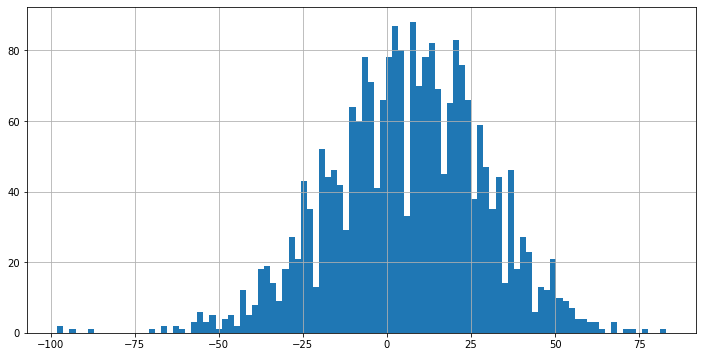

In [81]:
df['d'] = df['target'] - df['first_temp']
df['d'].hist(bins = 100, figsize = (12,6));

Мы видим нормальное распределение. Логично предположить, что какое-то колебание температуры неизбежно и его нельзя предсказать, иными словами, это шум. Однако, возможно, мы сможем предсказать отклонения от нормы. Тогда мы сможем понять, какие факторы влияют на отклонения температуры и дать подсказку бизнесу.

Мы будем считать, что стандартное отклонение и есть то самое неизбежное колебание. Пометим единицей все колебания, которые больше стандартного отклонения (в ту или иную сторону).

In [82]:
df['d_target']= df['d'].where(abs(df['d']) > df['d'].std(), 1)
df['d_target'] = df['d_target'].where(df['d_target'] != 1, 0)
df['d_target'] = df['d_target'].where(df['d_target'] == 0, 1)
df['d_target'] = df['d_target'].astype('int')
df.head(5)

,key,first_temp,heating_time_sum,energy_sum,energy_mean,power_max,Bulk 1,Bulk 3,Bulk 4,Bulk 6,...,Bulk 14,Bulk 15,Bulk_other,Wire 1,Wire 2,wire_other,gas_1,target,d,d_target
0,1,1571.0,1098.0,628.616930,125.723386,0.867133,0.0,0.0,43.0,0.0,...,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,1613.0,42.0,1
1,2,1581.0,811.0,395.281800,98.820450,0.786322,0.0,0.0,73.0,0.0,...,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,1602.0,21.0,0
2,3,1596.0,655.0,581.774624,116.354925,1.222963,0.0,0.0,34.0,0.0,...,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,1599.0,3.0,0
3,4,1601.0,741.0,543.710274,135.927569,0.887855,0.0,0.0,81.0,0.0,...,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,1625.0,24.0,1
4,5,1576.0,869.0,412.180480,103.045120,0.892957,0.0,0.0,78.0,0.0,...,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,1602.0,26.0,1


In [83]:
df['d_target'].mean()

0.3501075268817204

В среднем ~35% отклоняется. Попробуем использовать мою модель, но в данном случае, основанную на логистической регрессии, чтобы предсказать, будет ли температура отклоняться.

Подготовим данные.

In [84]:
X_log = df.drop(columns = ['target', 'key', 'd', 'd_target']).copy()
y_log = df['d_target'].copy()

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log,
                                                                    test_size=0.25, random_state=80523, shuffle=True)
X_train_log.shape, X_test_log.shape

((1743, 19), (582, 19))

In [85]:
features = ['heating_time_sum', 'energy_sum', 'energy_mean', 'power_max', 'Bulk_12', 'first_temp']
features = feature_selection(features)

In [86]:
X_train_cake_log, X_val_log, y_train_cake_log, y_val_log = train_test_split(X_train_log, y_train_log, 
                                                            test_size=0.25, random_state=80523, shuffle=True)
X_train_cake_log.shape, X_val_log.shape

((1307, 19), (436, 19))

##### Масштабирование признаков для логистических регрессий

In [87]:
# выбор метода масштабирования
scaler2 = StandardScaler()
# настройка масштабирования на тренировочной выборке: вычисление среднего и стандартного отклонения
scaler2.fit(X_train_cake_log)
# масштабирование тренировочной выборки
c = list(X_train_cake_log.columns)
X_train_scaler_log = X_train_cake_log.copy()
X_train_scaler_log[c] = scaler2.transform(X_train_cake_log)

X_val_scaler_log = X_val_log.copy()
X_val_scaler_log[c] = scaler2.transform(X_val_log)

# масштабирование тестовой выборки
X_test_scaler_log = X_test.copy()
X_test_scaler_log[c] = scaler2.transform(X_test)

Подберём параметры и обучим саму модель.

In [88]:
best_m = 0
best_f = []
best_i = 0
features.remove([])
for i in tqdm(range (1,4)):
    for i2 in tqdm(features):
        #print(i2)
        model = cake(i, LogisticRegression(solver = 'liblinear'), i2)
        model.fit(X_train_scaler_log, y_train_cake_log)
        pred = model.predict(X_val_scaler_log)
        f1 =  f1_score(pred, y_val_log)
        if f1 > best_m or best_m == 0:
            best_m = f1
            best_f = i2
            best_model = model
            best_i = i
print(best_m)
print('________________________')
print(best_f, best_i)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

0.8339483394833948
________________________
['heating_time_sum', 'first_temp'] 2


Протестируем получившуюся модель.

In [89]:
pred = best_model.predict(X_test_scaler_log)
f1 = f1_score(pred, y_test_log)
acc = accuracy_score(pred, y_test_log)
recall = recall_score(pred, y_test_log)
precision = precision_score(pred, y_test_log)

print('f1:', f1, 'acc:', acc, 'recall:', recall, 'precision:', precision)

f1: 0.7834549878345499 acc: 0.8470790378006873 recall: 0.8131313131313131 precision: 0.755868544600939


Наша модель не идеальна, но всё же может предсказывать отклонения. Она будет подспорьем для дальнейшего анализа.

### Оценка важности параметров

Наща модель cake состоит из отдельных линейных регрессий. Выше мы нормализовали признаки. Для оценки важности параметров, мы будем использовать их коэффициенты. Посмотрим на регресии внутри нашей модели:

In [90]:
report_reg = []
report_reg = my_model.report_()
report_reg

[['base', LinearRegression()],
 ['-inf<heating_time_sum<=0.9067346016210132', LinearRegression()],
 ['0.9067346016210132<heating_time_sum<=inf', LinearRegression()]]

Мы имеем три регрессии. 
- base : означает базовую регрессию, как если бы мы просто построили линейную регрессию.
- -inf<heating_time_sum<=0.9 - Эта регрессия строится на всех признаках, при условии, что время нагрева меньше 0.9 (с учётом нормализации)
- 0.9<heating_time_sum<=inf - Модель, которая строится на всех признаках, где время нагрева больше либо равно 0.9

Условно назовём веса для регрессии по всем признакам базой, где время меньше 0.9 - маленьким временем нагрева, а где больше - большим

In [91]:
a = scaler.inverse_transform([0.9067346016210132]*19)
b =  a[1] 
b

1096.4999999999998

<b>Реальный показатель</b> границы между "маленьким" и "большим" временем нагрева ~1096 секунд

In [92]:
report_list = report_reg.copy()
lin_list = []
for i in report_list:
    lin_list.append(i[1].coef_)
idx_list = []
for i in report_list:
    idx_list.append(i[0])

In [93]:
lin_df = pd.DataFrame(data = lin_list, columns = list(X_test_scaler.columns), 
                      index = ['База', 'Маленькое время нагрева', 'Большое время нагрева'])
lin_df

,first_temp,heating_time_sum,energy_sum,energy_mean,power_max,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk_12,Bulk 14,Bulk 15,Bulk_other,Wire 1,Wire 2,wire_other,gas_1
База,5.955854,7.514663,-2.413690,2.489074,-0.238233,-1.191312,-0.234172,0.217069,-1.218503,0.283308,-0.648644,-0.547480,-0.273961,1.061511,-1.134918,1.571294,-1.140839,-0.665688,-0.679466
Маленькое время нагрева,5.839437,7.617177,-2.517769,2.366207,-0.218466,-0.899714,-0.121493,0.106976,-1.162734,0.185211,-0.355625,-0.545163,-0.773327,1.147352,-1.798468,1.341457,-1.350047,-0.192596,-0.815583
Большое время нагрева,5.961036,5.733400,-3.539838,3.117999,0.452853,-2.302730,-0.019954,0.868896,-1.649495,0.805932,-1.099259,-1.104361,2.578054,0.911240,1.477385,2.712714,-0.881569,-3.026752,-0.337029


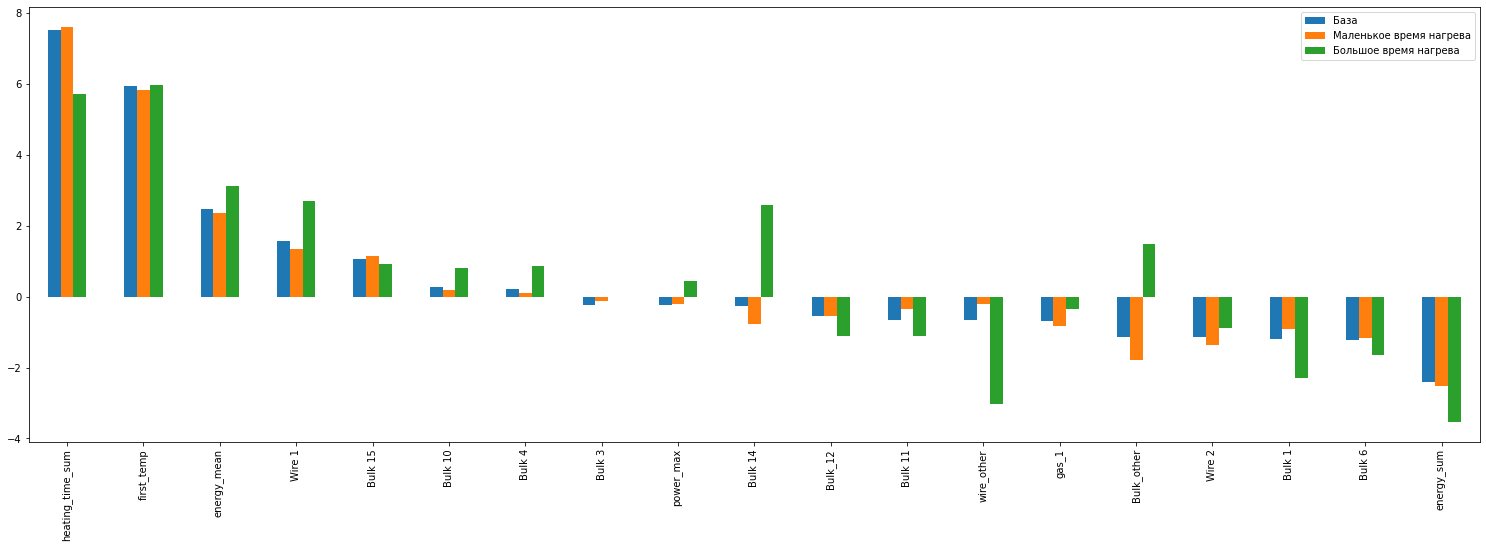

In [94]:
lin_df.transpose().sort_values(by = 'База', ascending = False).plot(kind='bar', figsize = (26,8));

Мы видим, что при маленьком времени нагрева картина схожа с базой, но при большом меняется - вплоть до того, что некоторые отрицательные веса становятся положительными. 

In [95]:
lin_df.transpose().sort_values(by='Маленькое время нагрева', 
                               ascending = False)['Маленькое время нагрева'].head(5)

heating_time_sum    7.617177
first_temp          5.839437
energy_mean         2.366207
Wire 1              1.341457
Bulk 15             1.147352
Name: Маленькое время нагрева, dtype: float64

In [96]:
lin_df.transpose().sort_values(by='Маленькое время нагрева', 
                               ascending = False)['Маленькое время нагрева'].tail(5)

Bulk 1       -0.899714
Bulk 6       -1.162734
Wire 2       -1.350047
Bulk_other   -1.798468
energy_sum   -2.517769
Name: Маленькое время нагрева, dtype: float64

При маленьком времени нагрева (< 1096 секунд) увеличивает температуру больше всего само время нагрева, средний показатель затраченной энергии (активная мощность * время), добавки Wire 1 и Bulk 15/

Уменьшают: как это ни удивительно, общая затраченная энергия, другие добавки, добавки Wire 2 и Bulk 6.

Начальная температура также увеличивает время нагрева, но как ни странно, она на втором месте. Кроме того, её можно не учитывать (очевидно, повлиять на неё нельзя).

In [97]:
lin_df.transpose().sort_values(by='Большое время нагрева', 
                               ascending = False)['Большое время нагрева'].head(5)

first_temp          5.961036
heating_time_sum    5.733400
energy_mean         3.117999
Wire 1              2.712714
Bulk 14             2.578054
Name: Большое время нагрева, dtype: float64

In [98]:
lin_df.transpose().sort_values(by='Большое время нагрева', 
                               ascending = False)['Большое время нагрева'].tail(5)

Bulk_12      -1.104361
Bulk 6       -1.649495
Bulk 1       -2.302730
wire_other   -3.026752
energy_sum   -3.539838
Name: Большое время нагрева, dtype: float64

При большом времени нагрева из увеличивающих факторов больше влияет Bulk 14, вместо Bulk 15, а также начальная температура. Из уменьшающих - Bulk 12, 6 и 1, а также другие wire

Посмотрим на значения для логистической регрессии, возможно, они что-то подскажут нам. Напомним, что целевое значение 1 = выбросы (т.е. разница между начальной и конечной температурой больше стандартного отклонения).

In [99]:
report_reg = []
report_reg = best_model.report_()
report_reg

[['base', LogisticRegression(solver='liblinear')],
 ['-inf<heating_time_sum<=0.9067346016210132 and -inf<first_temp<=0.07902674996900583',
  LogisticRegression(solver='liblinear')],
 ['-inf<heating_time_sum<=0.9067346016210132 and 0.07902674996900583<first_temp<=inf',
  LogisticRegression(solver='liblinear')],
 ['0.9067346016210132<heating_time_sum<=inf and -inf<first_temp<=0.07902674996900583',
  LogisticRegression(solver='liblinear')],
 ['0.9067346016210132<heating_time_sum<=inf and 0.07902674996900583<first_temp<=inf',
  LogisticRegression(solver='liblinear')]]

In [100]:
report_list = report_reg.copy()
log_list = []
for i in report_list:
    log_list.append(i[1].coef_.tolist())
idx_list = []
for i in report_list:
    idx_list.append(i[0])
    
log_list_final = []
for i in log_list:
    log_list_final.append(i[0])


In [101]:
log_df = pd.DataFrame(data = log_list_final, columns = list(X_test_scaler_log.columns),  index =idx_list)

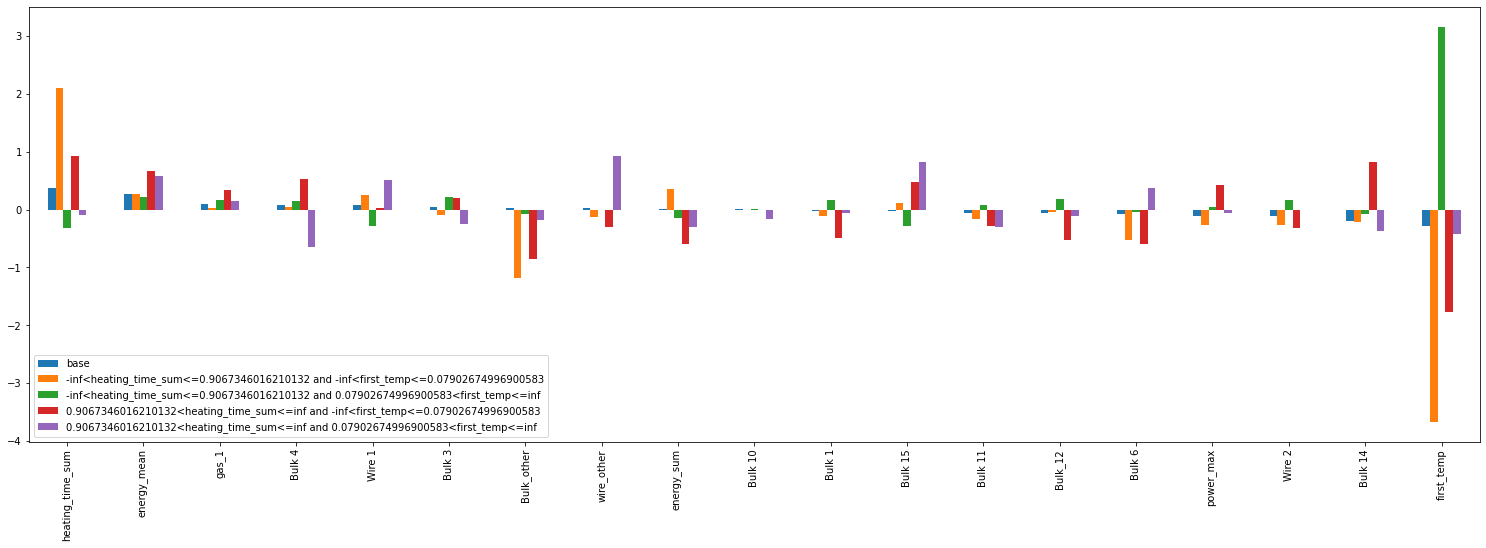

In [102]:
log_df.transpose().sort_values(by = 'base', ascending = False).plot(kind='bar', figsize = (26,8));

В случае логистической регрессии, наша модель разделила больше количество признаков. Анализировать каждый "кусочек неудобно", посмотрим среднее влияние каждого признака.

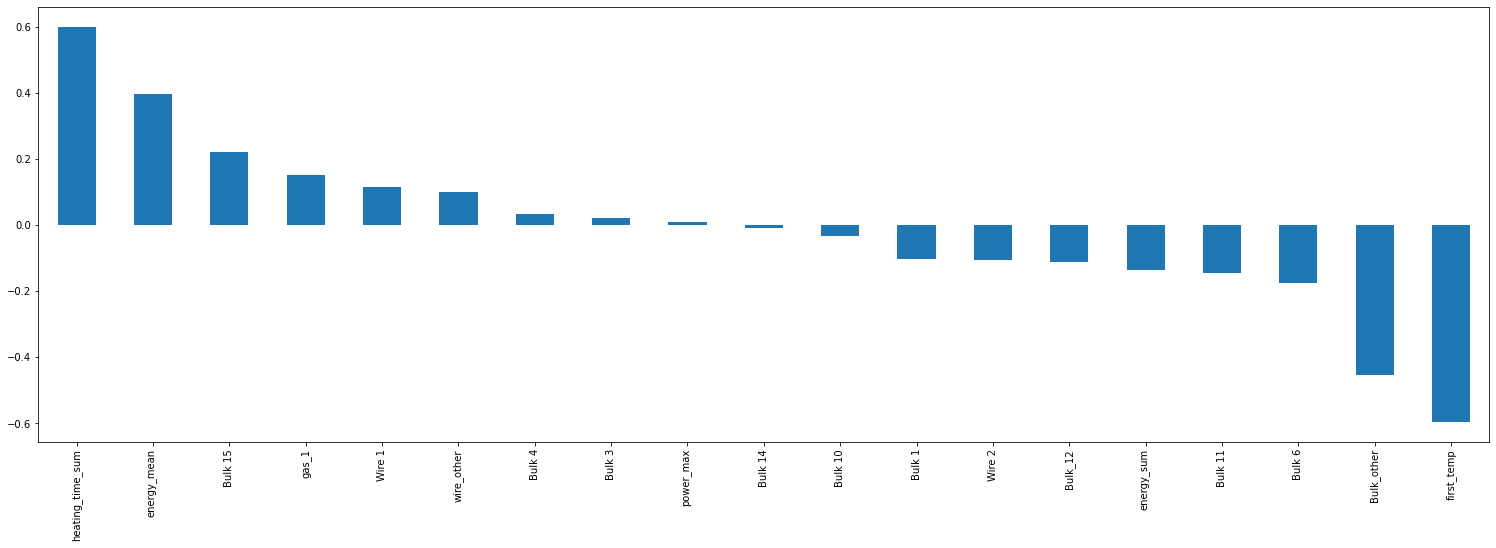

In [103]:
log_df.mean().sort_values(ascending = False).plot(kind='bar', figsize = (26,8));

In [104]:
log_df.mean().sort_values(ascending = False).head()

heating_time_sum    0.599845
energy_mean         0.396925
Bulk 15             0.222115
gas_1               0.151134
Wire 1              0.116153
dtype: float64

In [105]:
log_df.mean().sort_values(ascending = False).tail()

energy_sum   -0.134581
Bulk 11      -0.144930
Bulk 6       -0.174305
Bulk_other   -0.454322
first_temp   -0.596066
dtype: float64

Мы видим, что на нестабильность влияет больше всего время температуры, средняя энергия, добавка Bulk 15. Стабильности способствует начальная температура (чем выше - тем стабильней процесс), другие добавки и добавки Bulk 6 и 11.

## Финальный отчёт

Мы провели предварительную предобработку данных. В данных оказались ошибки, вызванные измерениями (не всегда есть температура и так далее). Мы избавились от выбросов, которые противоречат здравому смыслу (отрицательная реактивная мощность и слишком маленькая температура), однако оставили те выбросы, которые теоретически могут быть частью производственного процесса.
<br>
Мы обучили несколько моделей, используя различные преобразования и в результате добились MAE ~ 6.41, что соответствует ожиданиям заказчика.
<br>
Помимо этого, мы проанализировали важность признаков. Очевидный важный признак - начальная температура, но скорее всего, на него бизнес повлиять не может. Также очень важным признаком является время нагрева, т.е. чтобы уменьшить конечную температуру, стоит попытаться добиться того, чтобы нужный состав стали был получен быстрее, скорректировать итерации обработки так, чтобы сразу добиться нужного результат. На иные влияющие факторы вы можете подробней посмотреть в отчёте выше.
<br>
Также был произведён анализ факторов, влияющих на отклонение конечной температуры от начальной. 

<b>Ответы на 4 вопроса задания:</b>
- <i>Какие пункты были выполнены, а какие нет?</i>
- <i>Какие трудности возникли и как их преодолели?</i>
- <i>Какие ключевые шаги в решении задачи выделили?</i>
- <i>Какая ваша итоговая модель и какое у неё качество?</i>

1. Все пункты были выполнены.

2. Особых трудностей не возникло, в целом только технический вопрос (что-то надо было вспомнить и т.п.)

3. Был проведёт анализ данных, предобработка данных, обучение нескольких моделей с попутными трансформациями данных, выбор лучшей модели и анализ важности признаков.

4. Модель cake, MAE ~ 6.41

<b>Список признаков, используемых моделью и описание их предобработки:</b>

Для каждой модели перебирались разные наборы признаков. Был сгенерирован список списков признаков, а затем, во время обучений модели в цикле удалялись эти признаки. Но в итоговую модель вошли все признаки. Предобработка - нормализация Standart Scaler. 

<b>Гиперпараметры лучшей модели:</b>
глубина 2, признаки, которые модель делит - ['heating_time_sum']

<b>Что рекомендуете для улучшения модели:</b> возможно, стоило бы также перебрать признаки и исключить их, но учитывая, что там и так большой перебор идёт, мы были вынуждены отказаться (иначе бы её обучение заняло часы). Так же можно улучшить саму модель (идеи по её улучшению имеются).